In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import statsmodels.api as sm

from pmdarima import auto_arima

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [4]:
df_summary = pd.read_csv('Measurement_summary.csv')
df_summary.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


•	Проверка гипотез: в будние дни загрязненность воздуха ниже чем в выходные

In [5]:
df_summary = pd.read_csv('Measurement_summary.csv')
df_summary = df_summary.drop(['Address', 'Latitude', 'Longitude', 'Station code'], axis=1)

# Loop through columns and replace negative values with zero
for col in df_summary.columns[1:7]:  # specify the column range 
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')
    df_summary.loc[df_summary[col] < 0, col] = 0  # Replace negative values with zero


df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])


df_i_summary = df_summary.set_index('Measurement date')


df_day_sum = df_i_summary[: '2019-12-31'].resample('D').mean()
df_day_sum.head()

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-01,0.005293,0.046432,0.004145,0.983500,77.203333,56.775000
2017-01-02,0.006040,0.039293,0.016460,0.894667,109.246667,77.843333
2017-01-03,0.005602,0.042017,0.013223,0.762167,78.551667,51.538333
2017-01-04,0.005788,0.050480,0.008585,0.880167,54.968333,34.535000
2017-01-05,0.004788,0.035558,0.011392,0.658000,36.248333,22.170000


In [6]:
# Group the data
df_day_sum.reset_index(inplace=True)

df_day_sum['Weekday/Weekend'] = df_day_sum['Measurement date'].dt.dayofweek // 5  # 0 for weekdays, 1 for weekends
grouped_data = df_day_sum.groupby('Weekday/Weekend')

In [164]:
grouped_data.head()

,Measurement date,SO2,NO2,O3,CO,PM10,PM2.5,Weekday/Weekend
0,2017-01-01,0.005293,0.046432,0.004145,0.983500,77.203333,56.775000,1
1,2017-01-02,0.006040,0.039293,0.016460,0.894667,109.246667,77.843333,0
2,2017-01-03,0.005602,0.042017,0.013223,0.762167,78.551667,51.538333,0
3,2017-01-04,0.005788,0.050480,0.008585,0.880167,54.968333,34.535000,0
4,2017-01-05,0.004788,0.035558,0.011392,0.658000,36.248333,22.170000,0
5,2017-01-06,0.004458,0.035027,0.012730,0.530500,21.076667,13.256667,0
6,2017-01-07,0.005022,0.049277,0.004617,0.877667,53.938333,37.176667,1
7,2017-01-08,0.004412,0.031923,0.015080,0.589833,31.160000,21.726667,1
13,2017-01-14,0.003950,0.012817,0.023657,0.418833,43.903333,11.641667,1
14,2017-01-15,0.003973,0.021718,0.016118,1.079333,27.045000,13.593333,1


In [7]:
from scipy.stats import ttest_ind
# Perform statistical testing
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10','PM2.5']
for pollutant in pollutants:
    weekday_data = df_day_sum[df_day_sum['Weekday/Weekend'] == 0][pollutant]
    weekend_data = df_day_sum[df_day_sum['Weekday/Weekend'] == 1][pollutant]
    t_statistic, p_value = ttest_ind(weekday_data, weekend_data)
    
    # Interpret the results
    if p_value < 0.05:
        print(f"There is some difference in {pollutant} levels between weekdays and weekends.")
    else:
        print(f"There is no significant difference in {pollutant} levels between weekdays and weekends.")

There is no significant difference in SO2 levels between weekdays and weekends.
There is no significant difference in NO2 levels between weekdays and weekends.
There is no significant difference in O3 levels between weekdays and weekends.
There is no significant difference in CO levels between weekdays and weekends.
There is no significant difference in PM10 levels between weekdays and weekends.
There is no significant difference in PM2.5 levels between weekdays and weekends.


/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/1714100424.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')


<Figure size 800x600 with 0 Axes>

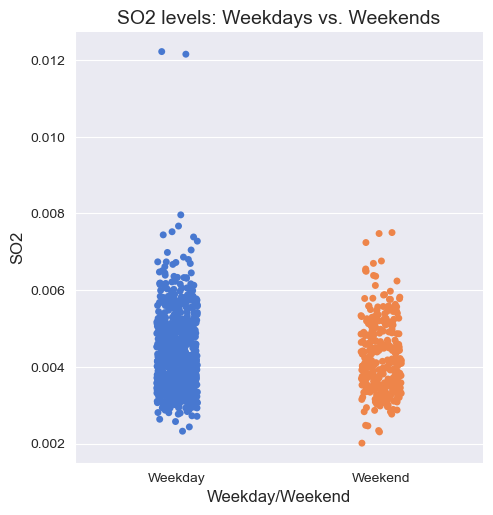

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/1714100424.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')


<Figure size 800x600 with 0 Axes>

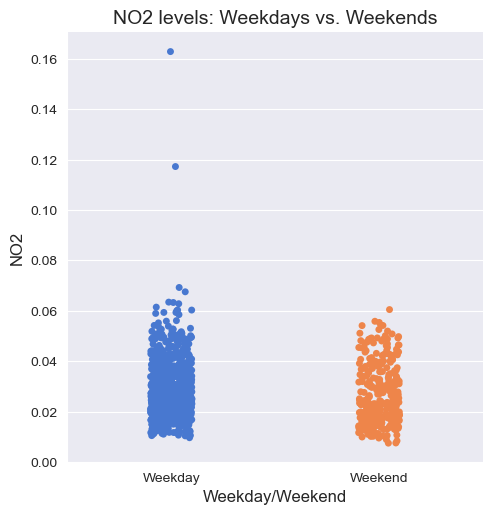

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/1714100424.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')


<Figure size 800x600 with 0 Axes>

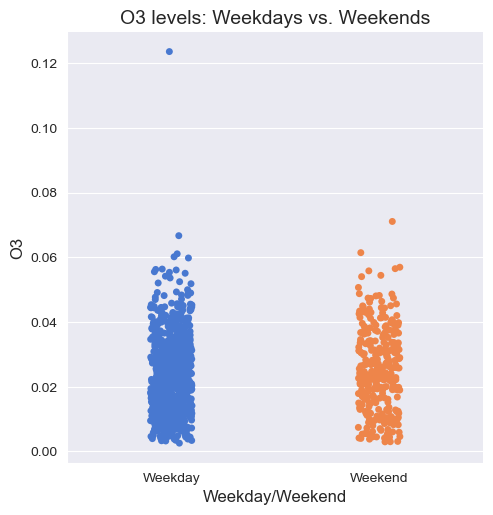

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/1714100424.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')


<Figure size 800x600 with 0 Axes>

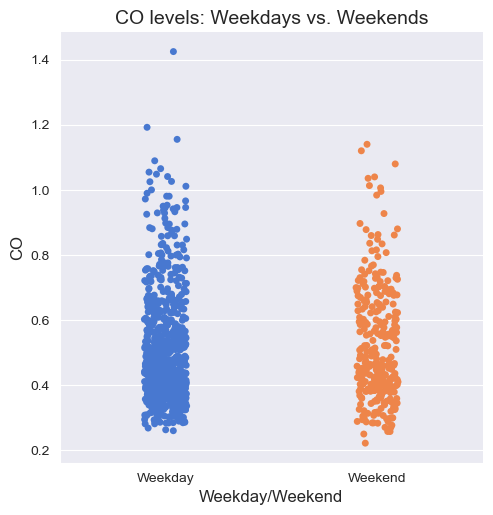

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/1714100424.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')


<Figure size 800x600 with 0 Axes>

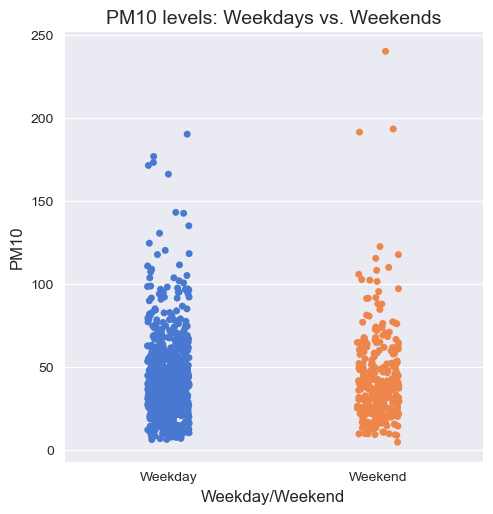

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/1714100424.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')


<Figure size 800x600 with 0 Axes>

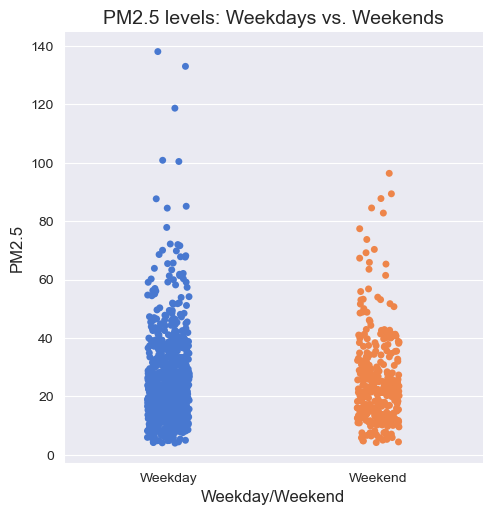

In [8]:
import seaborn as sns
sns.set_style("darkgrid")

for pollutant in pollutants:
    plt.figure(figsize=(8, 6))
    sns.catplot(data=df_day_sum, x='Weekday/Weekend', y=pollutant, palette='muted')
    plt.xlabel('Weekday/Weekend', fontsize=12)
    plt.ylabel(pollutant, fontsize=12)
    plt.title(f'{pollutant} levels: Weekdays vs. Weekends', fontsize=14)
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    plt.show()

In [9]:
df_summary = pd.read_csv('Measurement_summary.csv')

# Preprocess the data
df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])
df_summary['Weekday/Weekend'] = df_summary['Measurement date'].dt.dayofweek // 5  # 0 for weekdays, 1 for weekends
df_summary['Year'] = df_summary['Measurement date'].dt.year

# Group the data and calculate mean values
grouped_data = df_summary.groupby(['Year', 'Weekday/Weekend']).mean()

# Print the mean values
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

for pollutant in pollutants:
    print(f"Mean {pollutant} levels:")
    print(grouped_data[pollutant])
    print()

Mean SO2 levels:
Year  Weekday/Weekend
2017  0                  0.003271
      1                  0.003042
2018  0                 -0.001244
      1                 -0.000728
2019  0                 -0.007573
      1                 -0.008212
Name: SO2, dtype: float64

Mean NO2 levels:
Year  Weekday/Weekend
2017  0                  0.028445
      1                  0.026448
2018  0                  0.023715
      1                  0.022984
2019  0                  0.016559
      1                  0.014159
Name: NO2, dtype: float64

Mean O3 levels:
Year  Weekday/Weekend
2017  0                  0.022856
      1                  0.023719
2018  0                  0.017085
      1                  0.020638
2019  0                  0.011992
      1                  0.013810
Name: O3, dtype: float64

Mean CO levels:
Year  Weekday/Weekend
2017  0                  0.512895
      1                  0.530170
2018  0                  0.494409
      1                  0.494958
2019  0           

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/342623516.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = df_summary.groupby(['Year', 'Weekday/Weekend']).mean()


•	Прогностическое моделирование: можем ли мы предсказать  концентрацию газов на основе сезонных явлении?

In [11]:
df_summary = pd.read_csv('Measurement_summary.csv')
df_summary = df_summary.drop(['Address', 'Latitude', 'Longitude', 'Station code'], axis=1)

# Loop through columns and replace negative values with zero
for col in df_summary.columns[1:7]: 
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce') 
    df_summary.loc[df_summary[col] < 0, col] = 0  # Replace negative values with zero


df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])
df_i_summary = df_summary.set_index('Measurement date')

df_i_summary['2017']

/var/folders/9x/d3dvqy2x2fd3gntsc3m2t23c0000gn/T/ipykernel_57538/434754543.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_i_summary['2017']


,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-01 00:00:00,0.004,0.059,0.002,1.2,73.0,57.0
2017-01-01 01:00:00,0.004,0.058,0.002,1.2,71.0,59.0
2017-01-01 02:00:00,0.004,0.056,0.002,1.2,70.0,59.0
2017-01-01 03:00:00,0.004,0.056,0.002,1.2,70.0,58.0
2017-01-01 04:00:00,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...
2017-12-31 19:00:00,0.005,0.024,0.020,0.5,33.0,19.0
2017-12-31 20:00:00,0.005,0.019,0.023,0.4,44.0,12.0
2017-12-31 21:00:00,0.005,0.026,0.018,0.5,42.0,18.0


In [12]:
df_month_sum = df_i_summary[: '2019-12-31'].resample('M').mean()

In [80]:
df_month_sum.head()

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-01-31,0.005012,0.034788,0.014110,0.702651,52.752366,32.526935
2017-02-28,0.005055,0.034625,0.018249,0.634208,45.703214,28.546905
2017-03-31,0.005140,0.037669,0.024718,0.591720,59.455914,39.612527
2017-04-30,0.004966,0.031194,0.034605,0.504556,55.906278,26.234111
2017-05-31,0.005183,0.028162,0.038675,0.431543,62.747097,24.312634


In [13]:
df_sum_ser=validate_series(df_month_sum)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

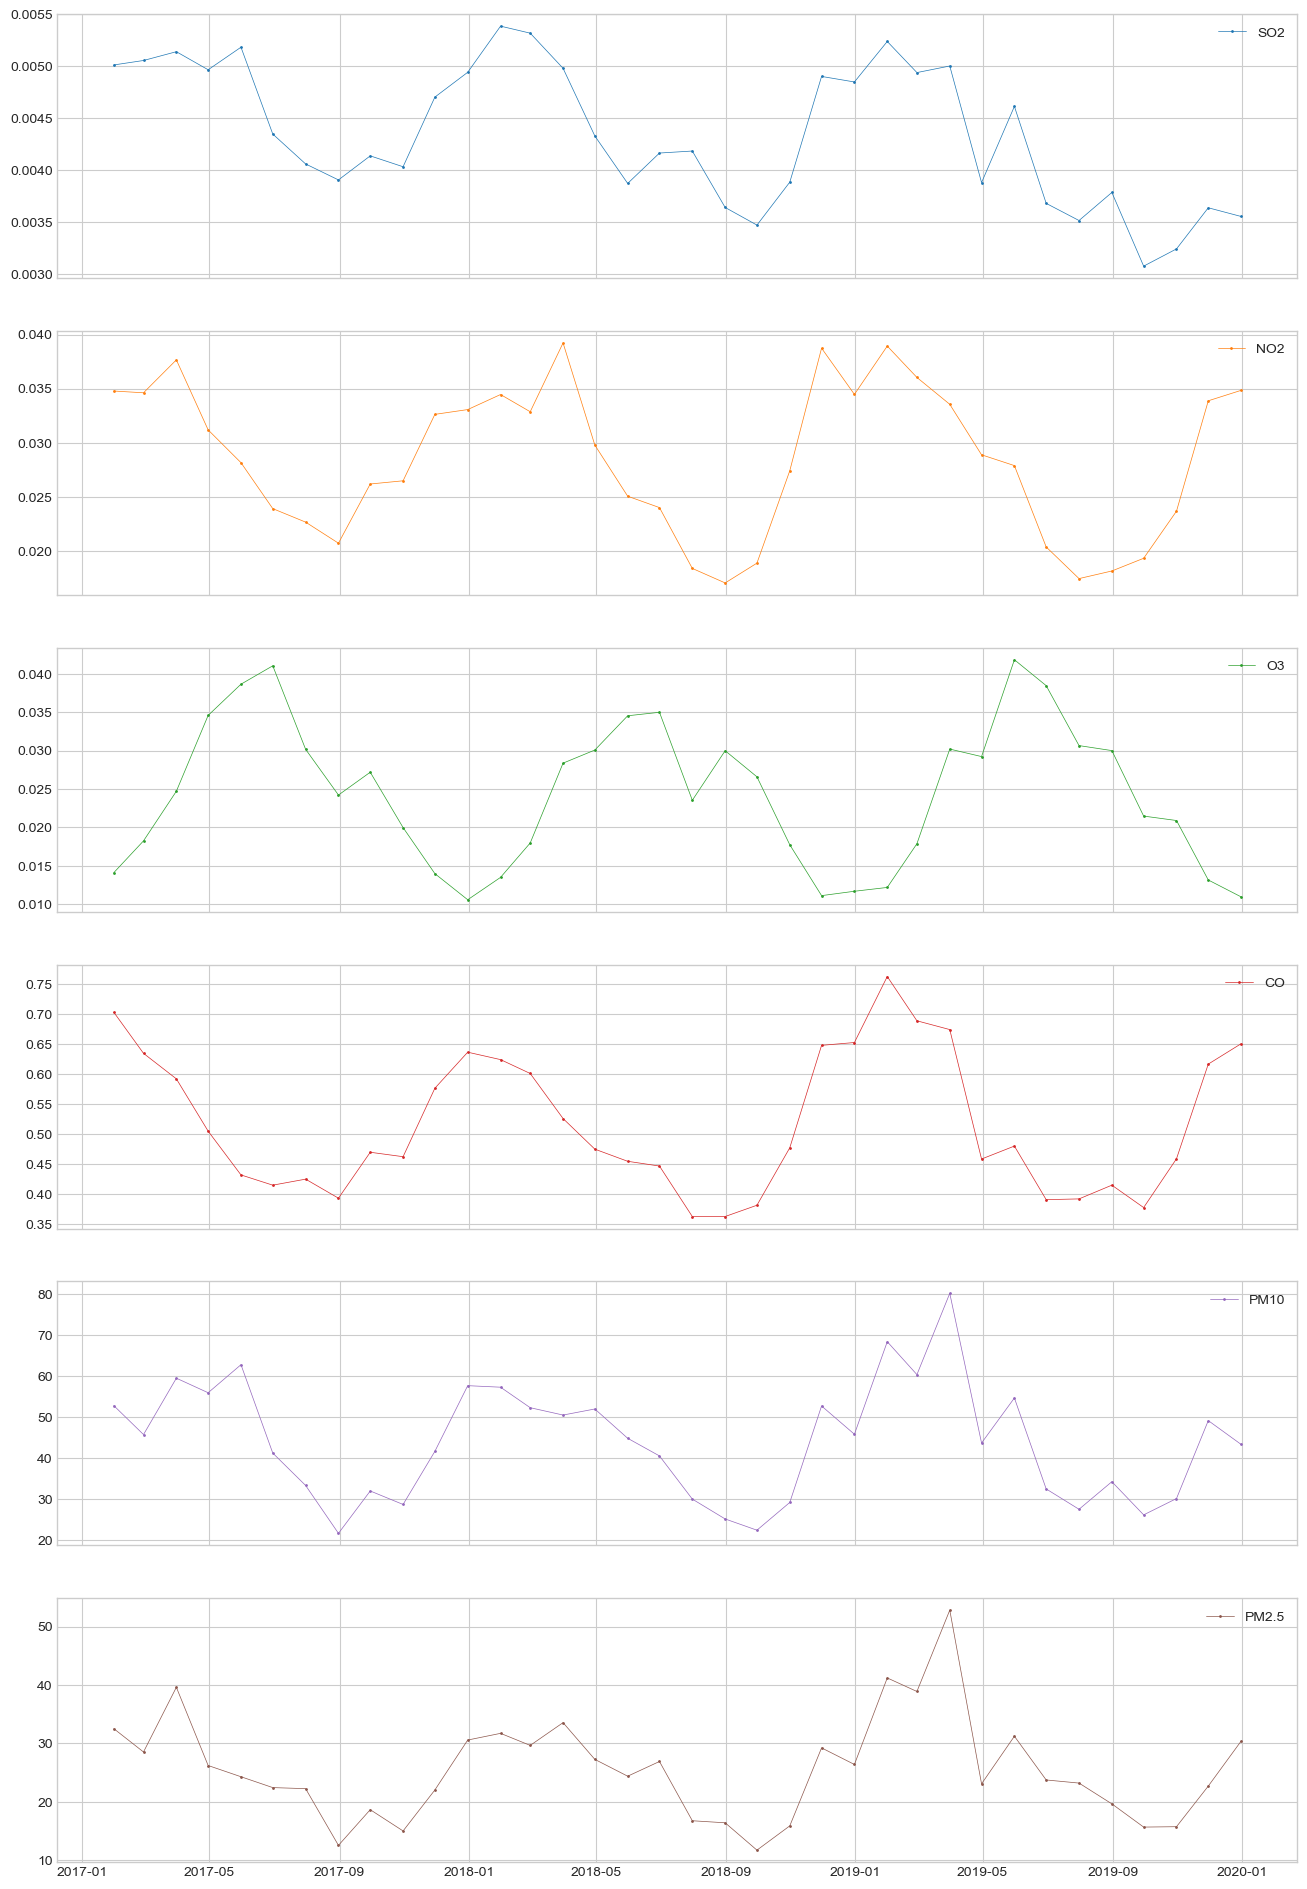

In [84]:
plot(df_sum_ser)

In [85]:
df_sum_ser.describe()

,SO2,NO2,O3,CO,PM10,PM2.5
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.004351,0.028486,0.024299,0.516897,44.016909,25.654282
std,0.000667,0.006903,0.009389,0.115031,14.154332,8.775422
min,0.003076,0.017042,0.010574,0.362204,21.608925,11.761778
25%,0.003850,0.023425,0.016832,0.422025,31.481829,19.425715
50%,0.004256,0.028526,0.024470,0.475686,44.220992,24.359462
75%,0.004969,0.034467,0.030193,0.626387,53.222022,30.452548
max,0.005386,0.039234,0.041861,0.762240,80.151095,52.802650


<Axes: xlabel='Measurement date'>

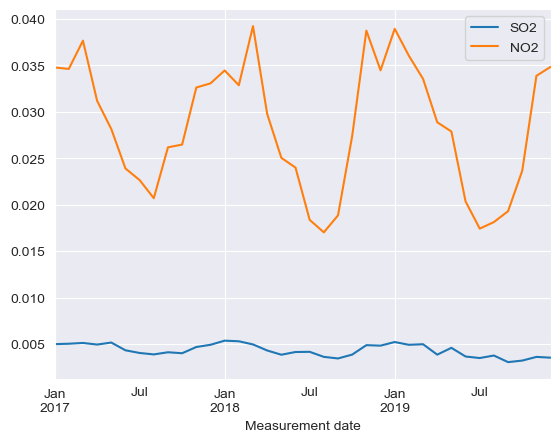

In [18]:
df_SO2_NO2_sum = df_sum_ser.drop(['O3', 'CO', 'PM10', 'PM2.5'], axis=1)
df_SO2_NO2_sum.plot()

In [20]:
df_SO2_sum = df_sum_ser.drop(['NO2', 'O3', 'CO', 'PM10', 'PM2.5'], axis=1)
df_NO2_sum = df_sum_ser.drop(['SO2', 'O3', 'CO', 'PM10', 'PM2.5' ], axis=1)
df_O3_sum = df_sum_ser.drop(['SO2', 'NO2', 'CO', 'PM10', 'PM2.5'], axis=1)
df_CO_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'PM10', 'PM2.5'], axis=1)
df_PM10_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'CO', 'PM2.5'], axis=1)
df_PM2_5_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'CO', 'PM10'], axis=1)

<Axes: xlabel='Measurement date'>

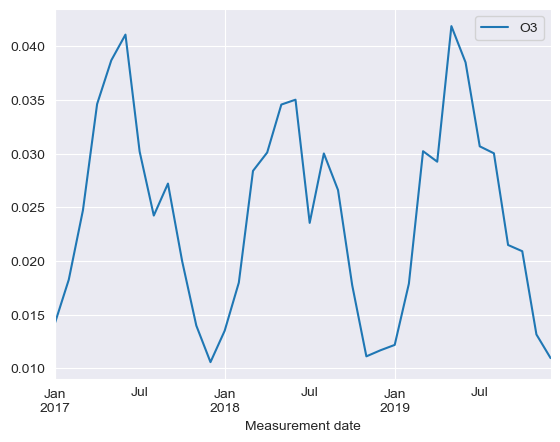

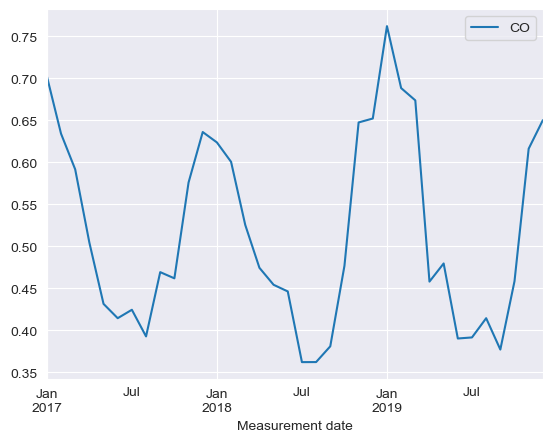

In [24]:
df_O3_sum.plot()
df_CO_sum.plot()

<Axes: xlabel='Measurement date'>

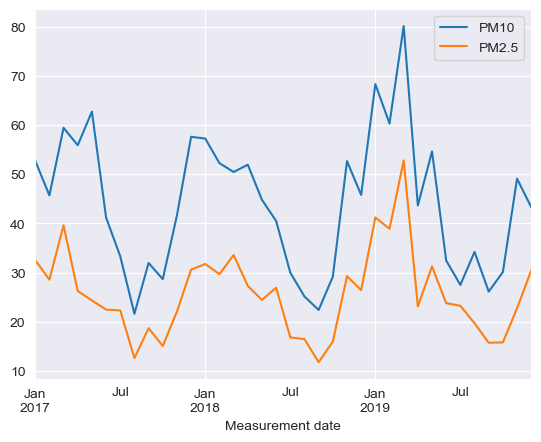

In [25]:
df_PM_O3_PM2_5_sum = df_sum_ser.drop(['SO2', 'NO2', 'O3', 'CO'], axis=1)
df_PM_O3_PM2_5_sum.plot()

/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


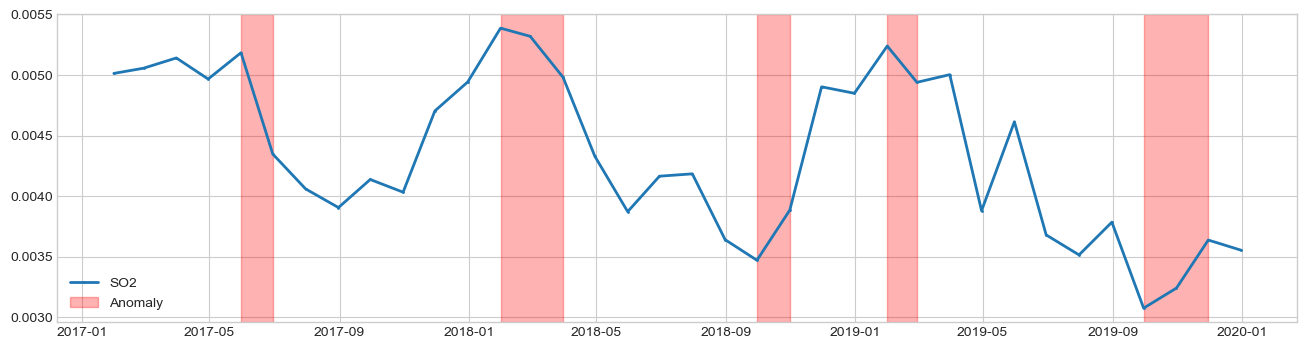

In [92]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.2))
anomalies_SO2 = outlier_detector.fit_detect(df_SO2_sum)
plot(df_SO2_sum, anomaly=anomalies_SO2, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

[<Axes: >]

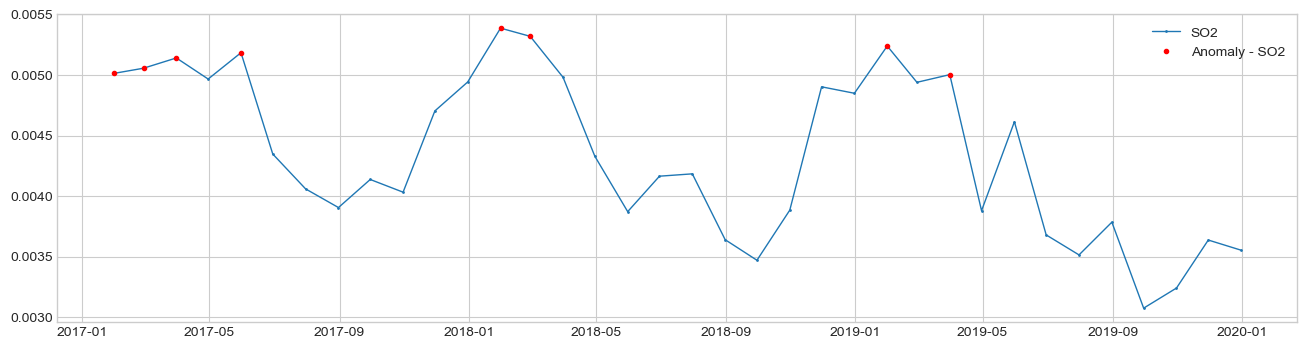

In [95]:
threshold = ThresholdAD(high=0.005, low=0.003)
anomalies_SO2 = threshold.detect(df_SO2_sum)
plot(df_SO2_sum, anomaly=anomalies_SO2, ts_linewidth=1, anomaly_markersize=3, anomaly_color='red', anomaly_tag='marker')

In [96]:
anomalies_SO2[anomalies_SO2.SO2]

,SO2
Measurement date,
2017-01-31,True
2017-02-28,True
2017-03-31,True
2017-05-31,True
2018-01-31,True
2018-02-28,True
2019-01-31,True
2019-03-31,True


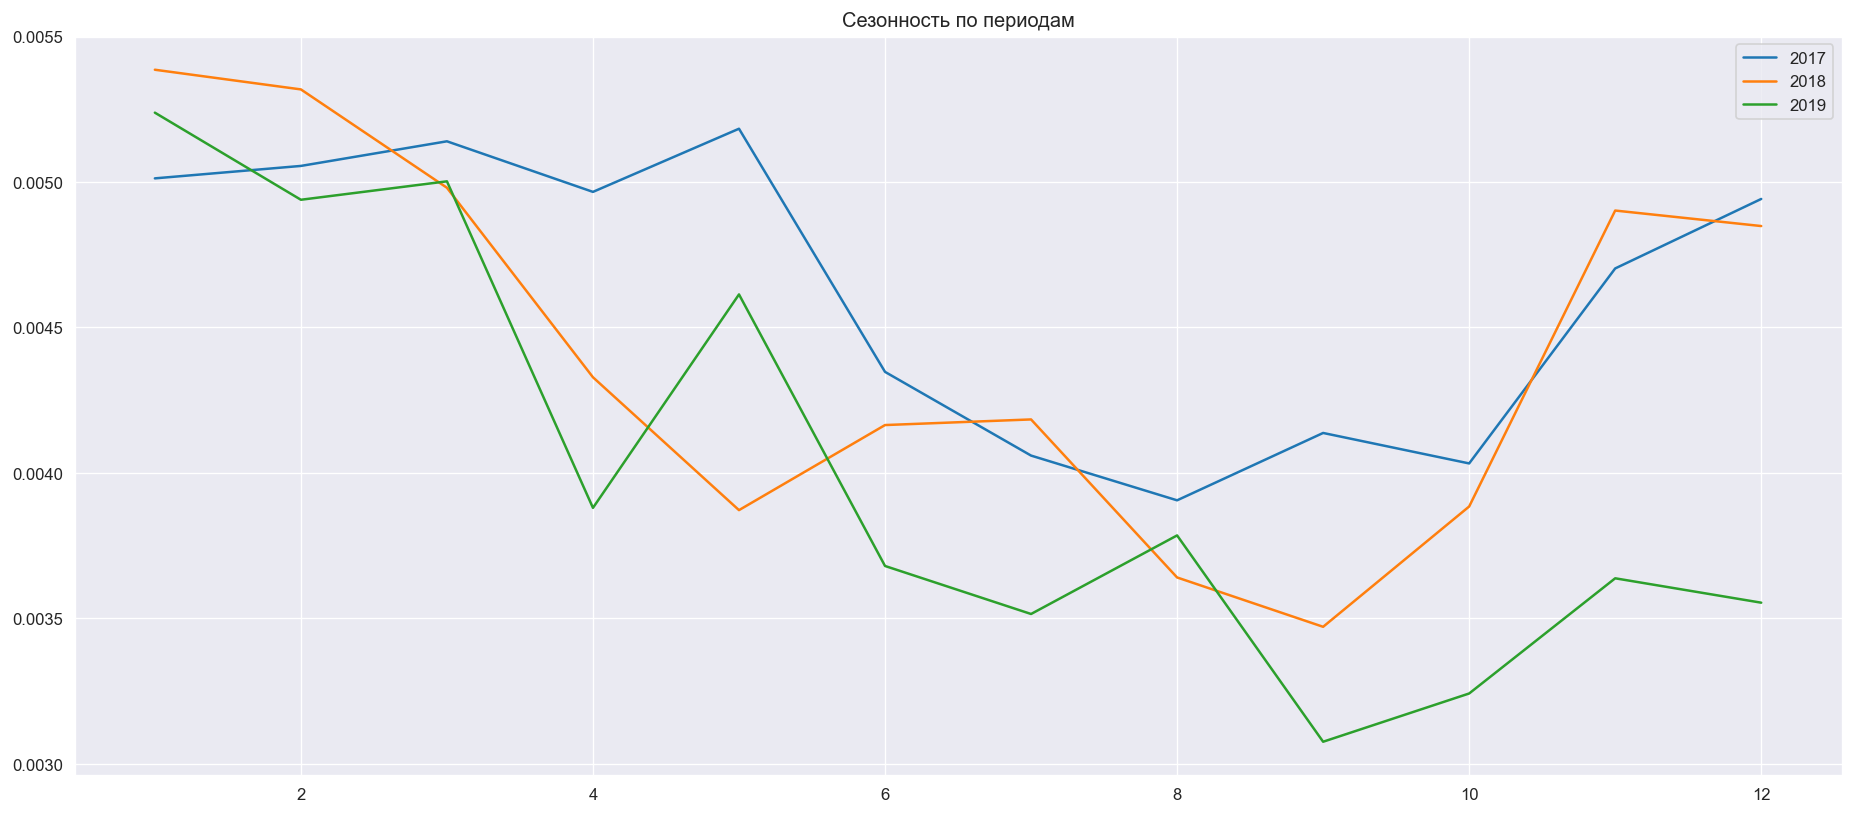

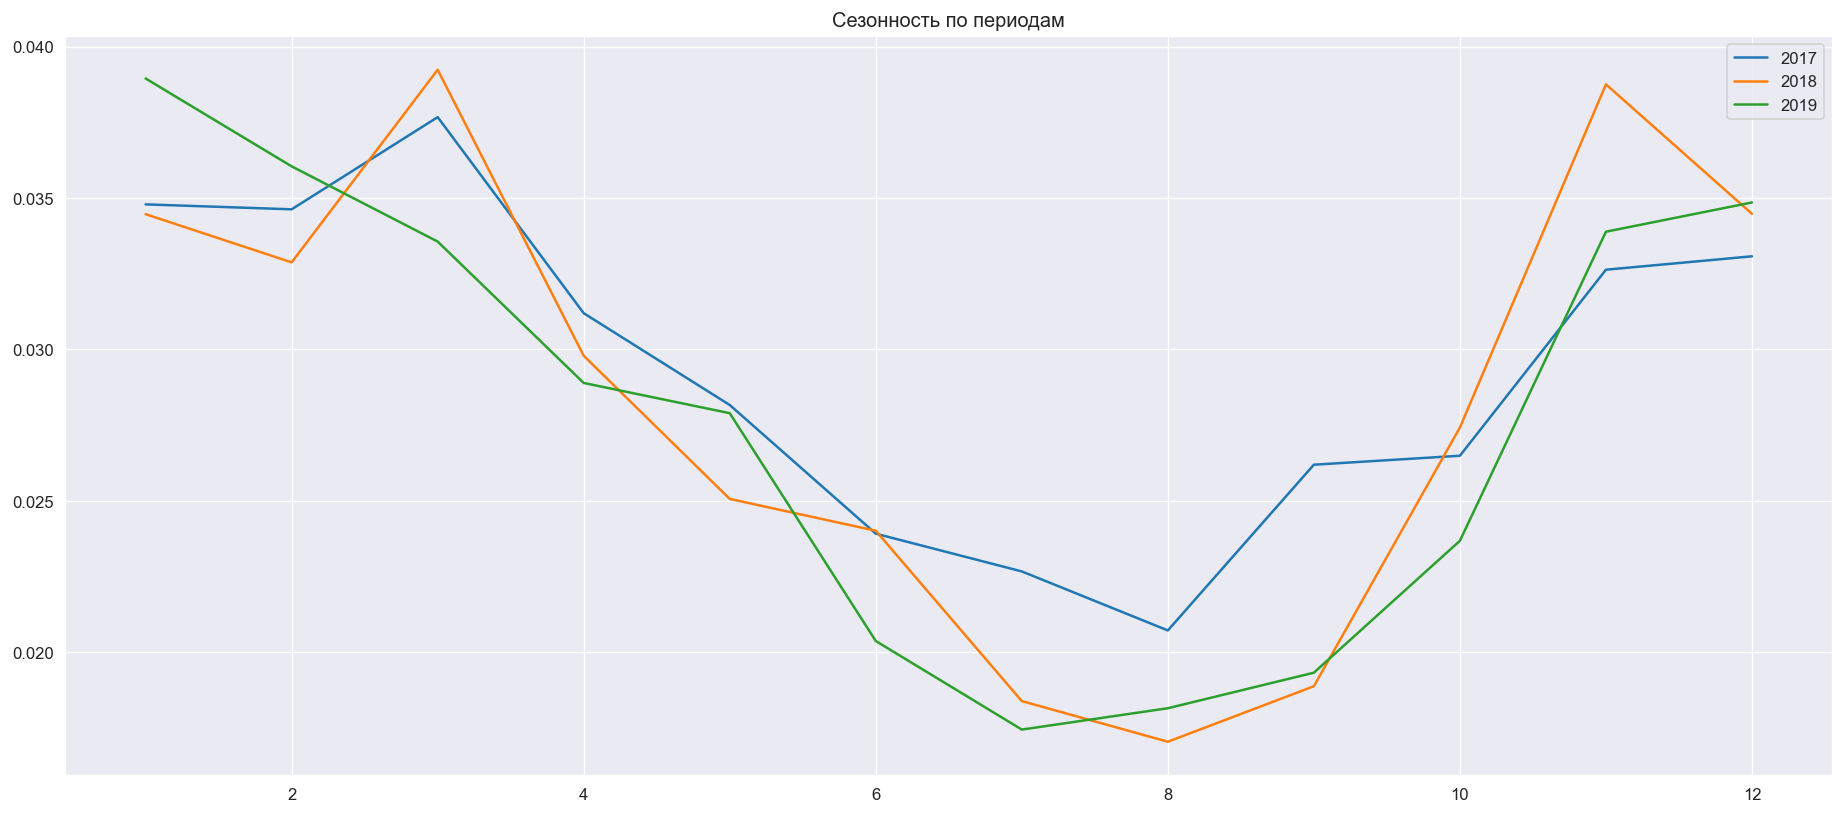

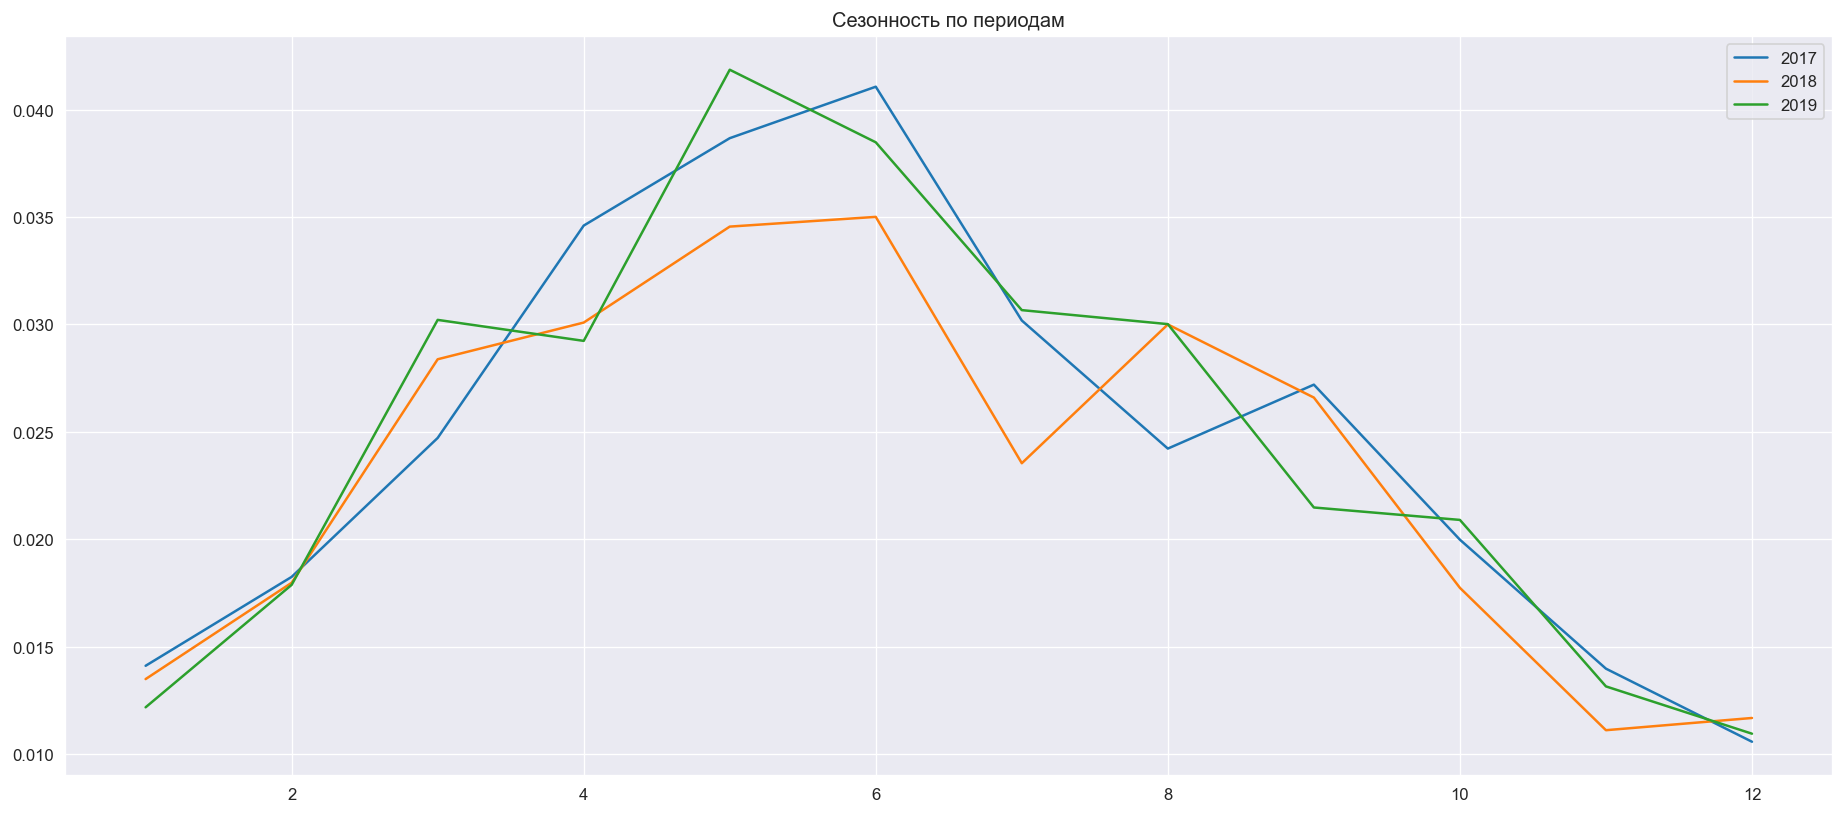

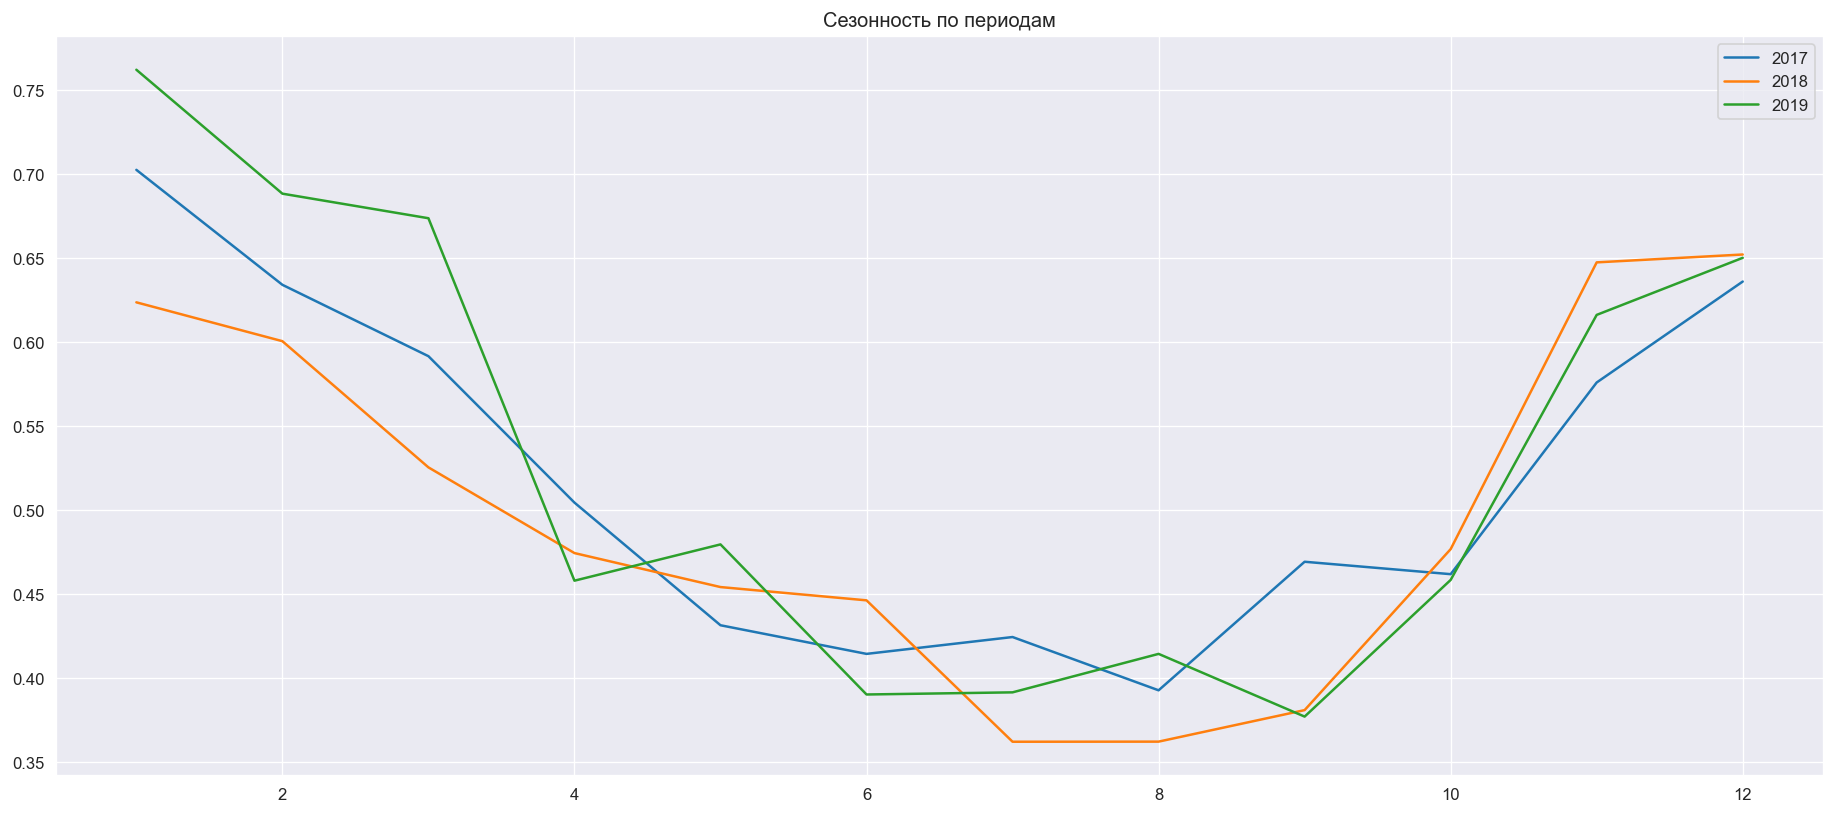

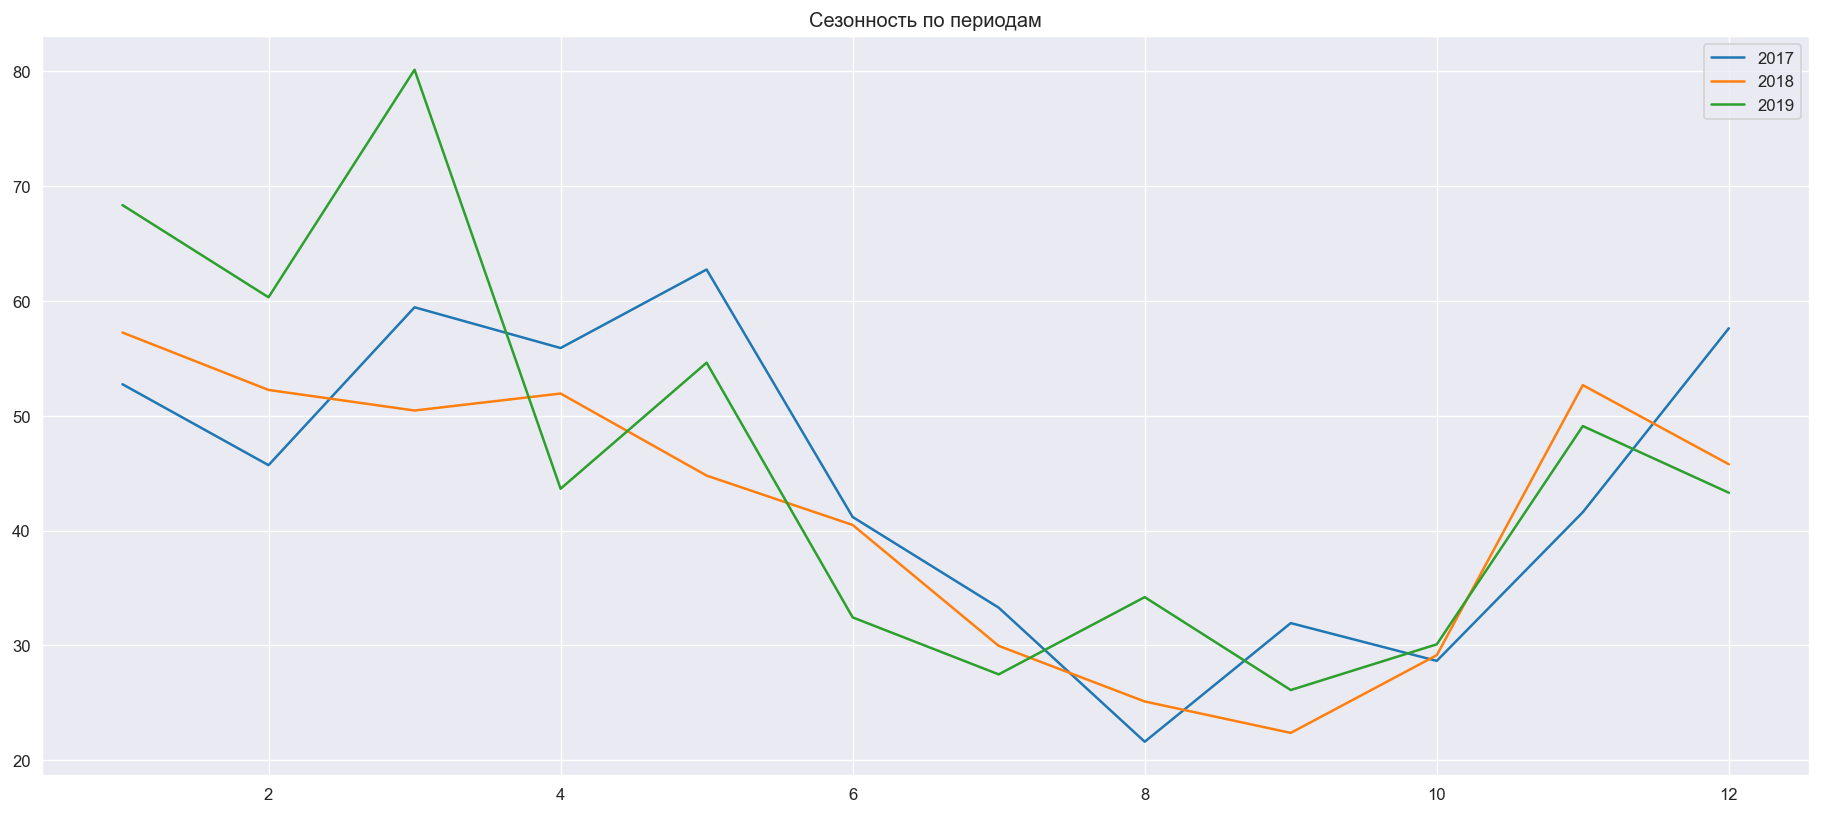

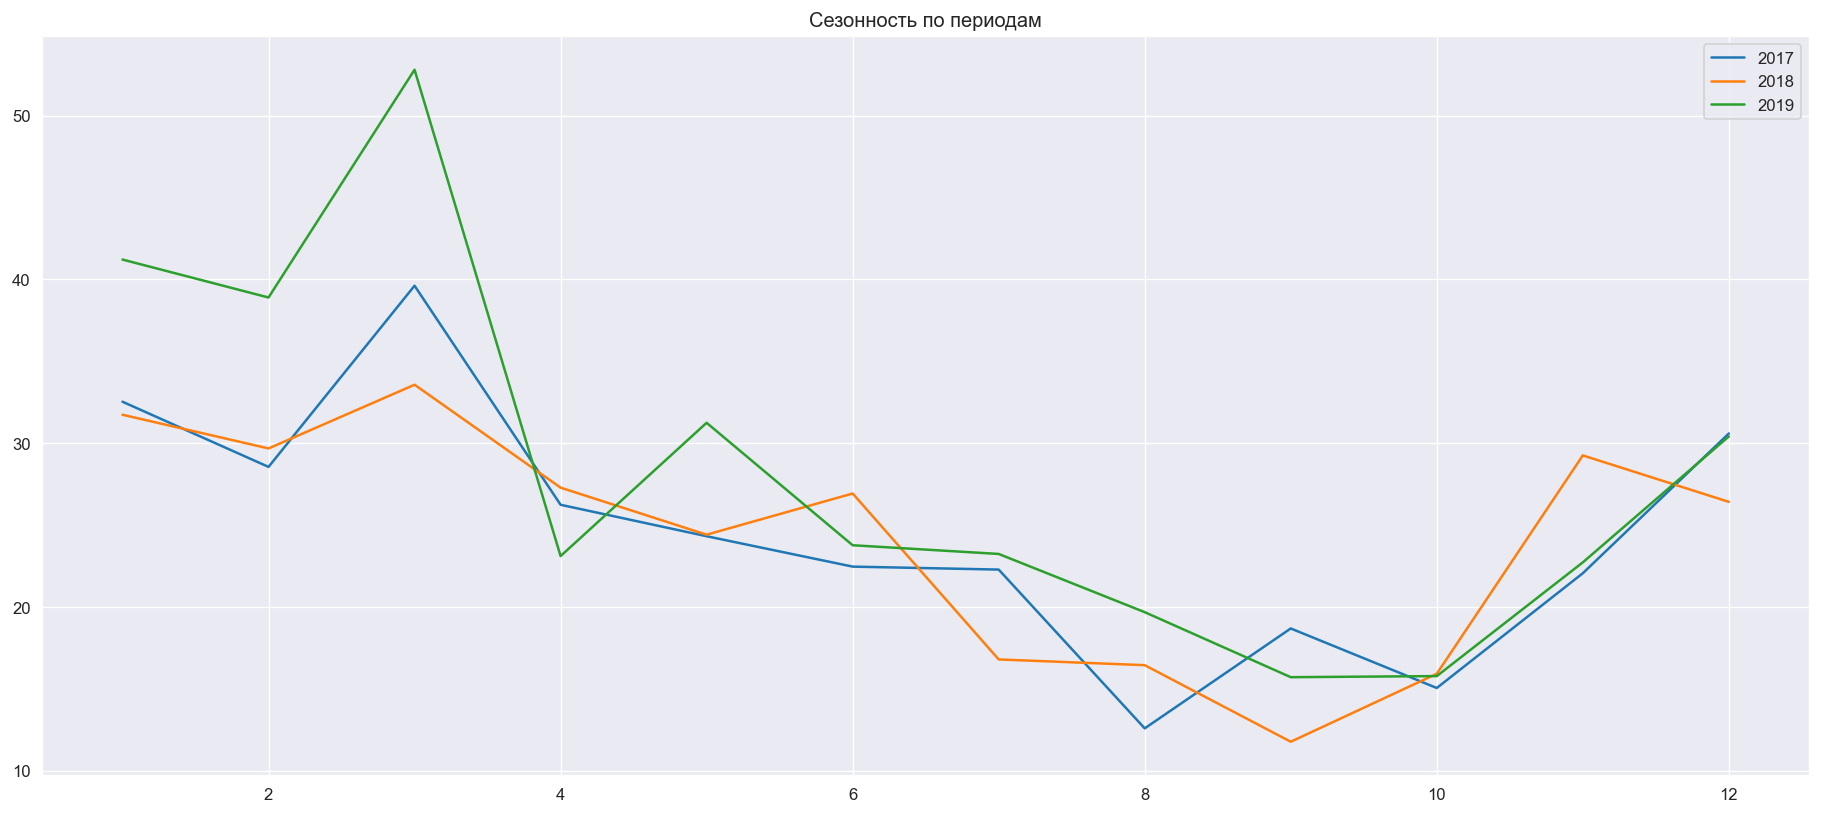

In [31]:
# функция графика сезонности
def sesonal(data):
    plt.figure(figsize=(19,8), dpi= 120)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df_SO2_sum)
sesonal(df_NO2_sum)
sesonal(df_O3_sum)
sesonal(df_CO_sum)
sesonal(df_PM10_sum)
sesonal(df_PM2_5_sum)


Text(0.5, 0.98, 'Мультипликативная модель')

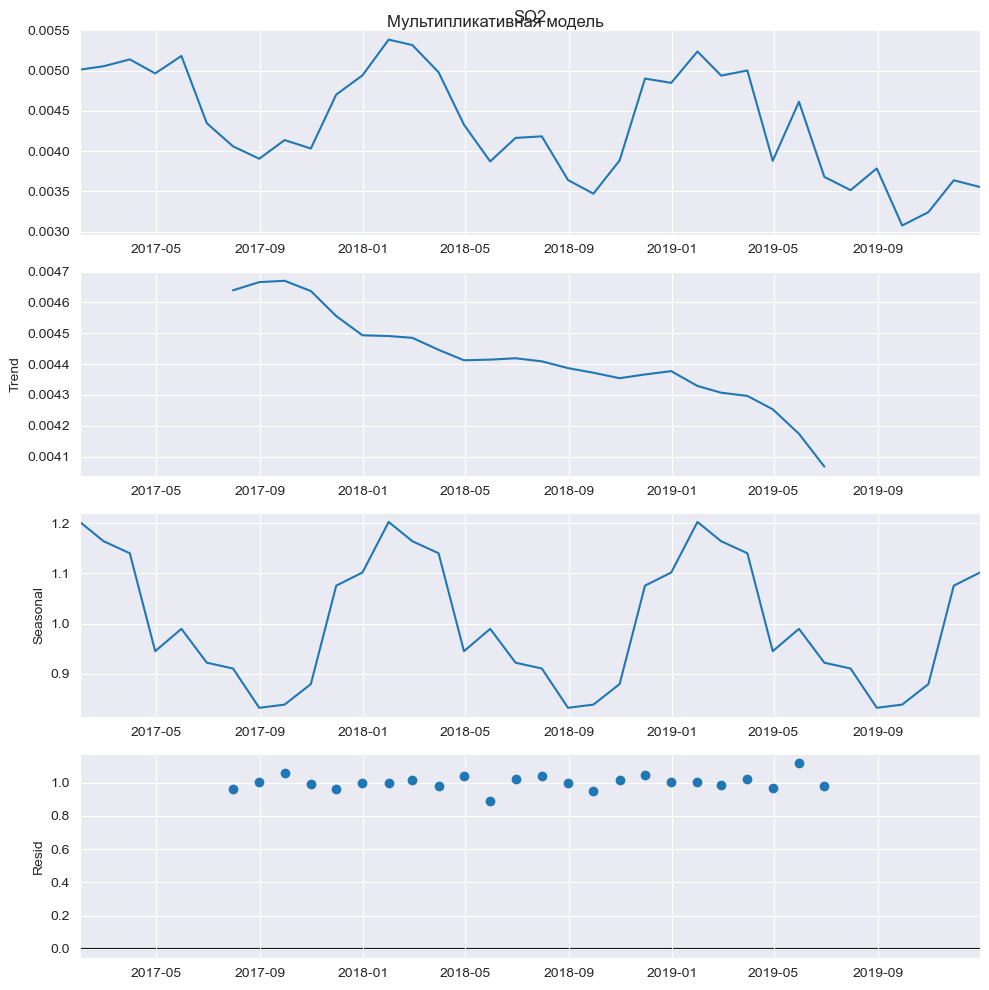

In [34]:
# декомпозиция
result_M_SO2 = seasonal_decompose(df_SO2_sum.SO2, model='multiplicative', period=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M_SO2.plot().suptitle('Мультипликативная модель')

In [35]:
result_M_SO2.seasonal['2017']

Measurement date
2017-01-31    1.202474
2017-02-28    1.164093
2017-03-31    1.140061
2017-04-30    0.944872
2017-05-31    0.989394
2017-06-30    0.921899
2017-07-31    0.910336
2017-08-31    0.831967
2017-09-30    0.838380
2017-10-31    0.879289
2017-11-30    1.075505
2017-12-31    1.101730
Freq: M, Name: seasonal, dtype: float64

In [60]:
model = auto_arima(df_SO2_sum, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True, trend='t')
model

Performing stepwise search to minimize aic


/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-429.546, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-322.882, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-350.825, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-322.882, Time=0.03 sec


/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-431.546, Time=1.03 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-433.546, Time=0.28 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-406.591, Time=7.26 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-435.534, Time=0.03 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-408.389, Time=0.36 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-433.534, Time=0.15 sec


/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/daniilpogolovkin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-431.534, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-364.829, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-433.884, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=-273.831, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-352.825, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=-316.947, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-434.153, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=-312.945, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[12]             : AIC=-435.534, Time=0.02 sec

Best model:  ARIMA(1,0,2)(0,0,0)[12]          
Total fit time: 13.520 seconds


ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, trend='t', with_intercept=False)

In [61]:
mod = sm.tsa.statespace.SARIMAX(df_SO2_sum,
                                order=(1, 0, 2),
                                seasonal_order=(0, 0, 0, 12))

results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.19280D+00    |proj g|=  1.85698D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     25      1     0     0   6.432D+00  -6.194D+00
  F =  -6.1940983993880439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9880      0.012    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


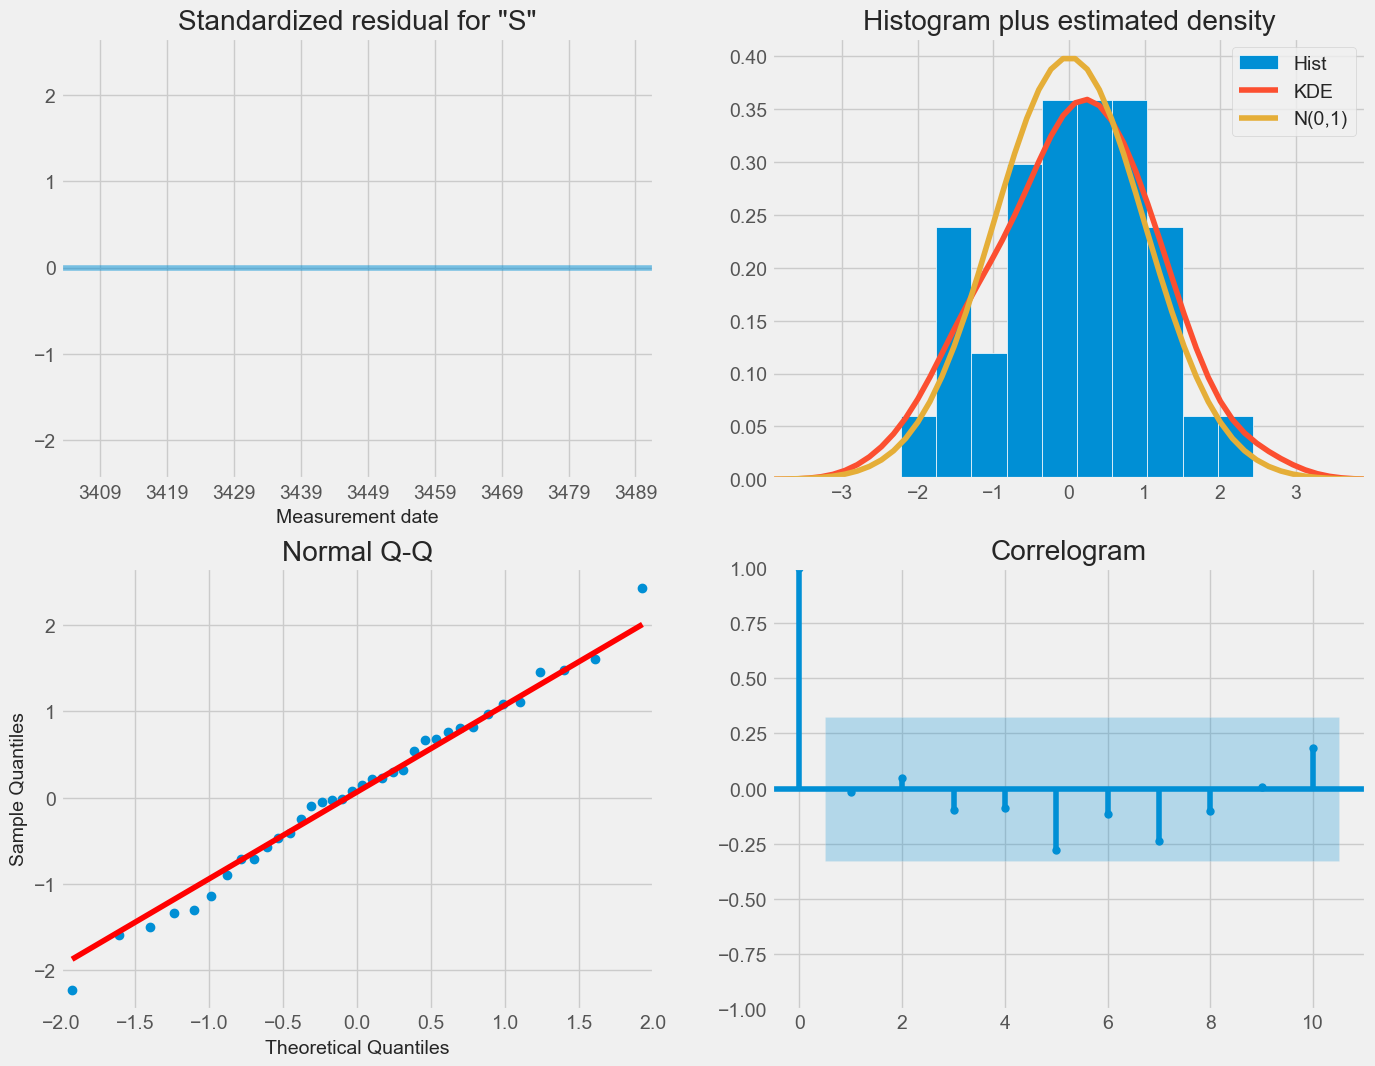

In [62]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [66]:
def metrics(real, forecast):

    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values

    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))

    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4))

In [68]:
predict=results.get_prediction()
metrics(df_SO2_sum, predict.predicted_mean)

Тест на стационарность:
	T-статистика = -11.835
	P-значение = 0.000
Критические значения :
	1%: -3.6327426647230316 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9485102040816327 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6130173469387756 - Данные  стационарны с вероятностью 90% процентов
MAD: 0.0005
MSE: 0.0
MAPE: 0.1122
MPE: 0.0246
Стандартная ошибка: 0.0009


In [69]:
predict=results.get_prediction(start='2019-12-31', end='2020-06-01')

In [70]:
predict.predicted_mean

2019-12-31    0.003564
2020-01-31    0.003575
2020-02-29    0.003531
2020-03-31    0.003489
2020-04-30    0.003447
2020-05-31    0.003405
2020-06-30    0.003365
Freq: M, Name: predicted_mean, dtype: float64

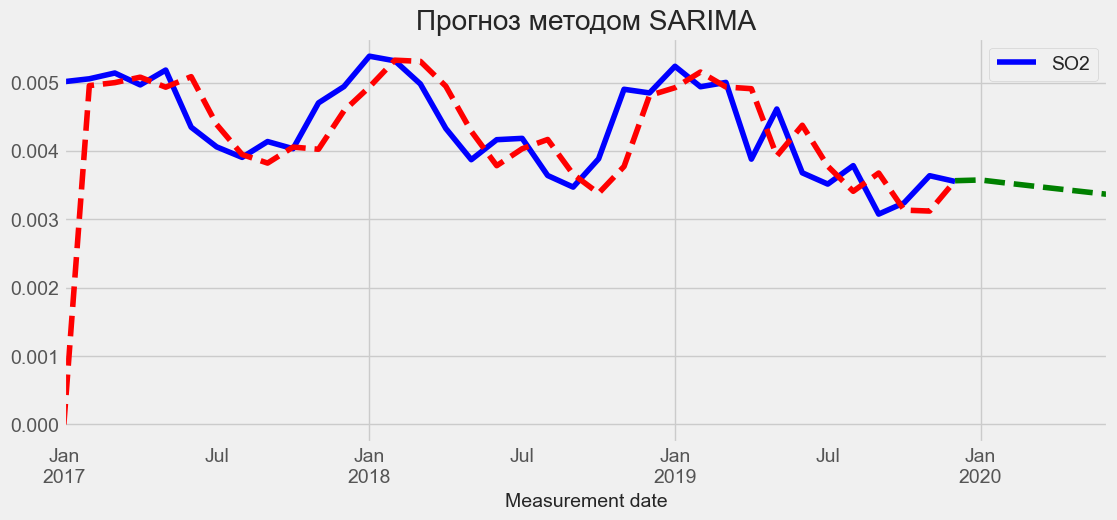

In [71]:
ax = df_SO2_sum.plot(figsize=(12,5), color='blue', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [73]:
fit_SO2 = ExponentialSmoothing(df_SO2_sum, seasonal_periods=12, trend='mul', seasonal='add').fit()

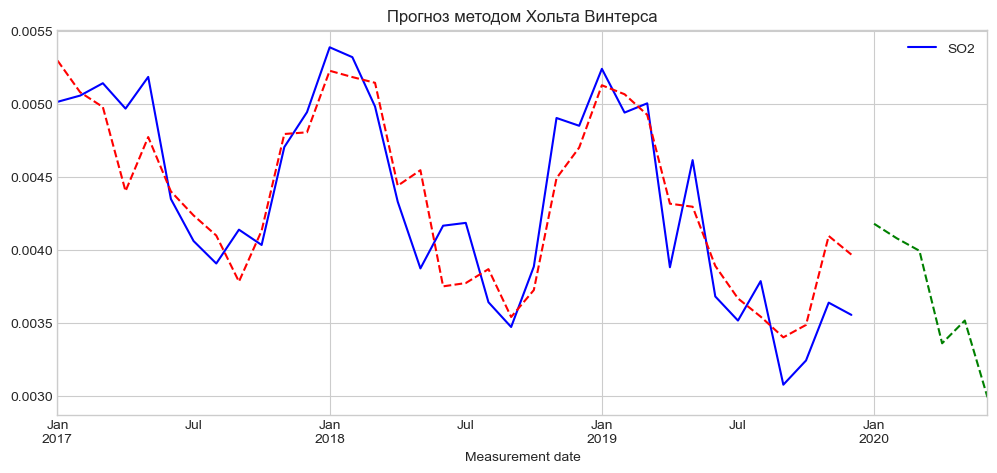

In [122]:
ax = df_SO2_sum.plot(figsize=(12,5), color='blue', title="Прогноз методом Хольта Винтерса" )
fit_SO2.fittedvalues.plot(ax=ax, style='--', color='red')
fit_SO2.forecast(6).plot(ax=ax, style='--', color='green')
plt.show()

In [123]:
fit_SO2.params

{'smoothing_level': 0.39392857454734304,
 'smoothing_trend': 9.99284821588407e-05,
 'smoothing_seasonal': 9.993432469443782e-05,
 'damping_trend': nan,
 'initial_level': 0.004620262771944509,
 'initial_trend': 0.9935701563466728,
 'initial_seasons': array([ 7.04633660e-04,  6.27498412e-04,  5.64087949e-04, -4.72480974e-05,
         1.30498491e-04, -3.73135603e-04, -4.86563388e-04, -5.25133397e-04,
        -7.36041247e-04, -4.97456999e-04,  2.32467533e-04,  3.08270296e-04]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [124]:
fit_SO2.fittedvalues

Measurement date
2017-01-31    0.005295
2017-02-28    0.005078
2017-03-31    0.004977
2017-04-30    0.004401
2017-05-31    0.004771
2017-06-30    0.004399
2017-07-31    0.004235
2017-08-31    0.004097
2017-09-30    0.003782
2017-10-31    0.004130
2017-11-30    0.004792
2017-12-31    0.004804
2018-01-31    0.005225
2018-02-28    0.005182
2018-03-31    0.005143
2018-04-30    0.004438
2018-05-31    0.004544
2018-06-30    0.003749
2018-07-31    0.003772
2018-08-31    0.003867
2018-09-30    0.003539
2018-10-31    0.003724
2018-11-30    0.004489
2018-12-31    0.004699
2019-01-31    0.005126
2019-02-28    0.005064
2019-03-31    0.004923
2019-04-30    0.004315
2019-05-31    0.004294
2019-06-30    0.003889
2019-07-31    0.003666
2019-08-31    0.003542
2019-09-30    0.003400
2019-10-31    0.003485
2019-11-30    0.004094
2019-12-31    0.003966
Freq: M, dtype: float64

In [125]:
fit_SO2.forecast(6)

2020-01-31    0.004178
2020-02-29    0.004078
2020-03-31    0.003993
2020-04-30    0.003359
2020-05-31    0.003515
2020-06-30    0.002990
Freq: M, dtype: float64

In [74]:
metrics(df_SO2_sum, fit_SO2.fittedvalues)

Тест на стационарность:
	T-статистика = -5.015
	P-значение = 0.000
Критические значения :
	1%: -3.6327426647230316 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9485102040816327 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6130173469387756 - Данные  стационарны с вероятностью 90% процентов
MAD: 0.0002
MSE: 0.0
MAPE: 0.0584
MPE: -0.0073
Стандартная ошибка: 0.0003


Text(0.5, 0.98, 'Мультипликативная модель')

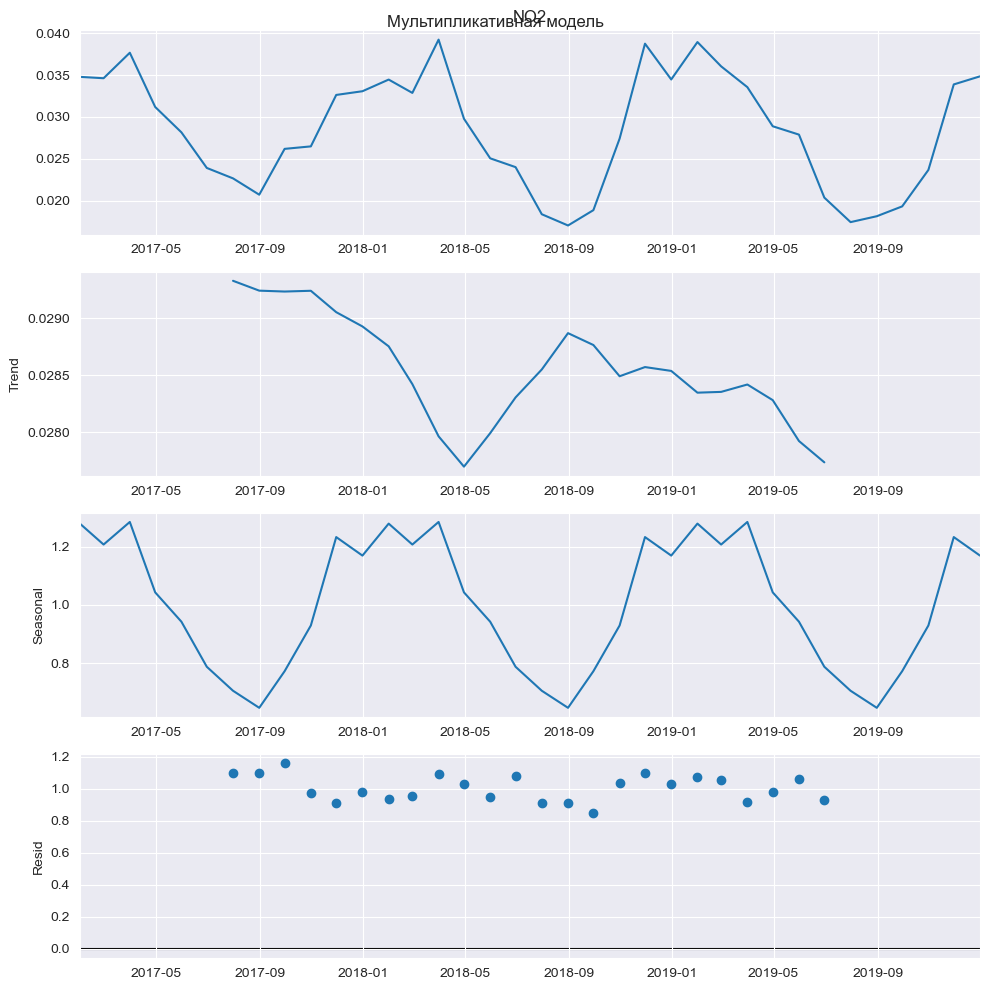

In [41]:
# декомпозиция
result_M_NO2 = seasonal_decompose(df_NO2_sum.NO2, model='multiplicative', period=12)

result_M_NO2.plot().suptitle('Мультипликативная модель')

In [43]:
result_M_NO2.seasonal['2018']

Measurement date
2018-01-31    1.279610
2018-02-28    1.207629
2018-03-31    1.285302
2018-04-30    1.043099
2018-05-31    0.942205
2018-06-30    0.787226
2018-07-31    0.704719
2018-08-31    0.646034
2018-09-30    0.772010
2018-10-31    0.929244
2018-11-30    1.233309
2018-12-31    1.169612
Freq: M, Name: seasonal, dtype: float64

Text(0.5, 0.98, 'Мультипликативная модель')

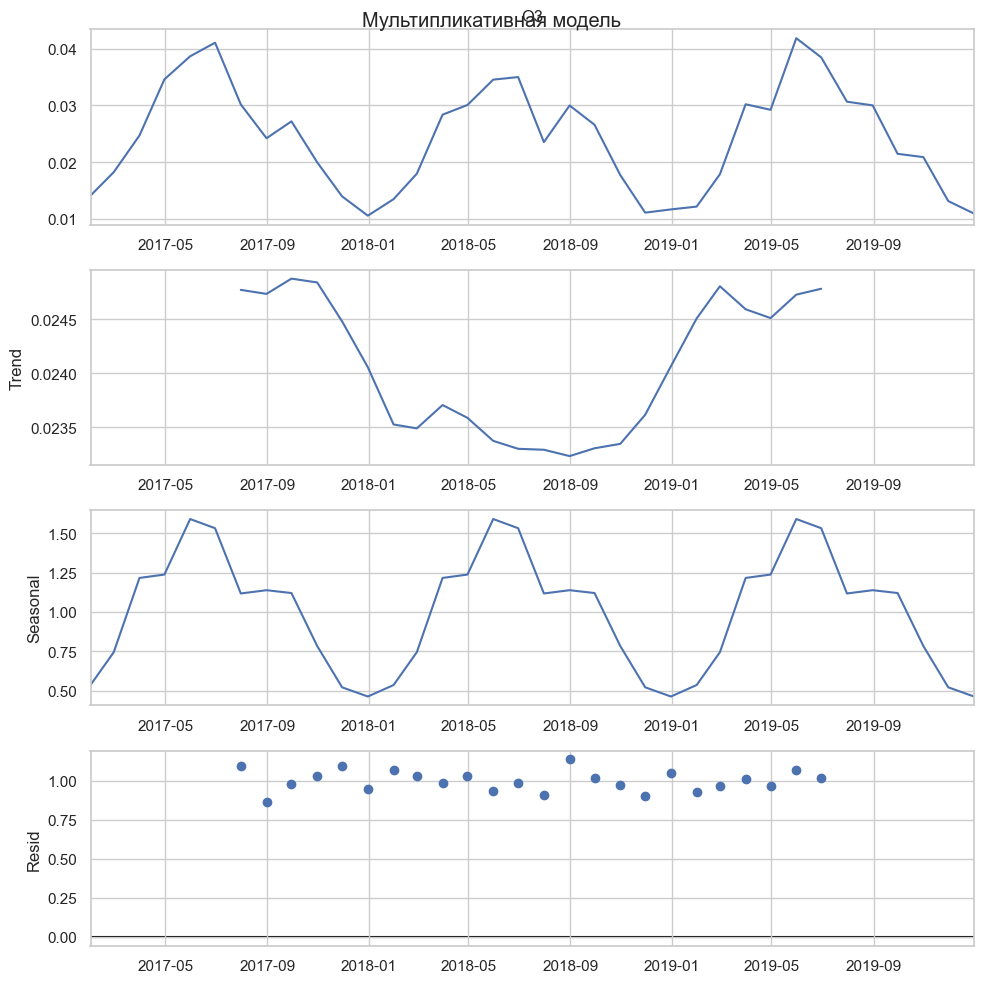

In [255]:
# декомпозиция
result_M_O3 = seasonal_decompose(df_O3_sum.O3, model='multiplicative', period=12)

result_M_O3.plot().suptitle('Мультипликативная модель')

Text(0.5, 0.98, 'Аддитивная модель модель')

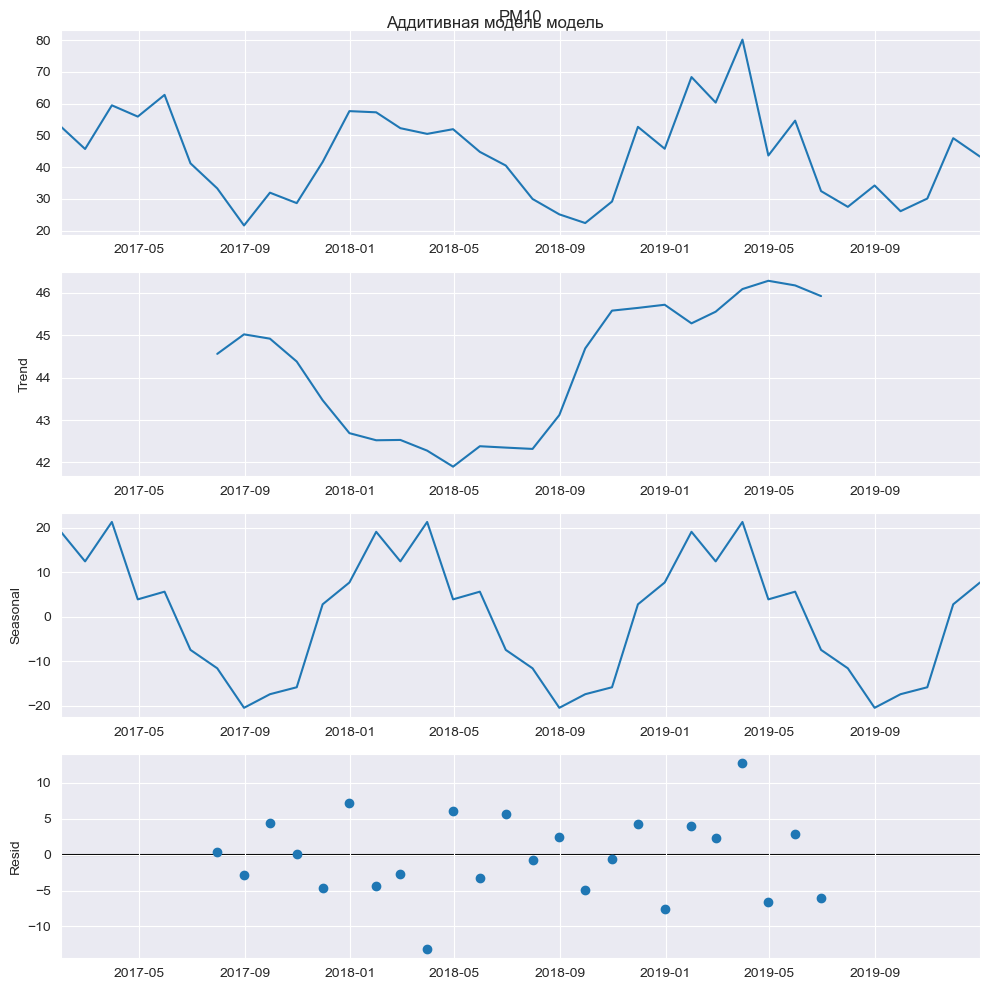

In [44]:
# декомпозиция
result_A_PM10 = seasonal_decompose(df_PM10_sum.PM10, model='additive', period=12)

result_A_PM10.plot().suptitle('Аддитивная модель модель')

Text(0.5, 0.98, 'Аддитивная модель модель')

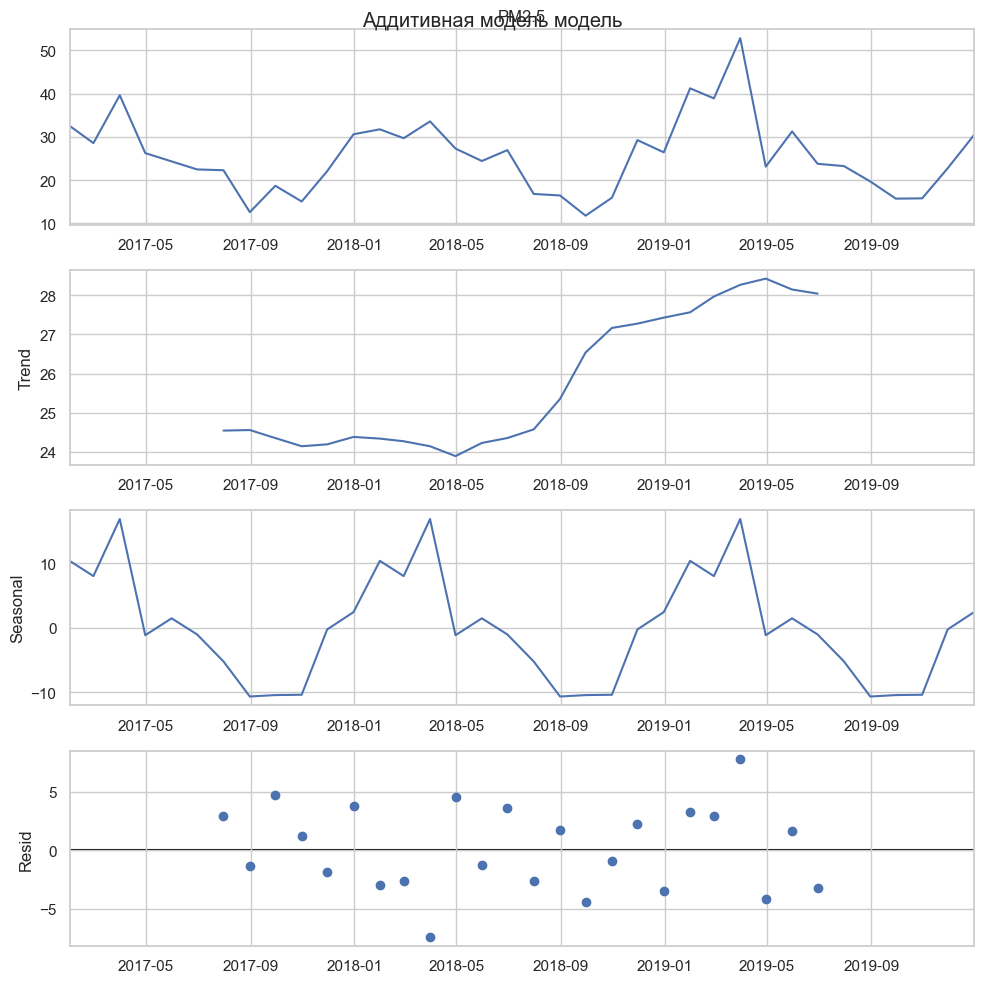

In [261]:
# декомпозиция
result_A_PM2_5 = seasonal_decompose(df_PM2_5_sum['PM2.5'], model='additive', period=12)

result_A_PM2_5.plot().suptitle('Аддитивная модель модель')

In [45]:
fit_PM10 = ExponentialSmoothing(df_PM10_sum, seasonal_periods=12, trend='mul', seasonal='add').fit()

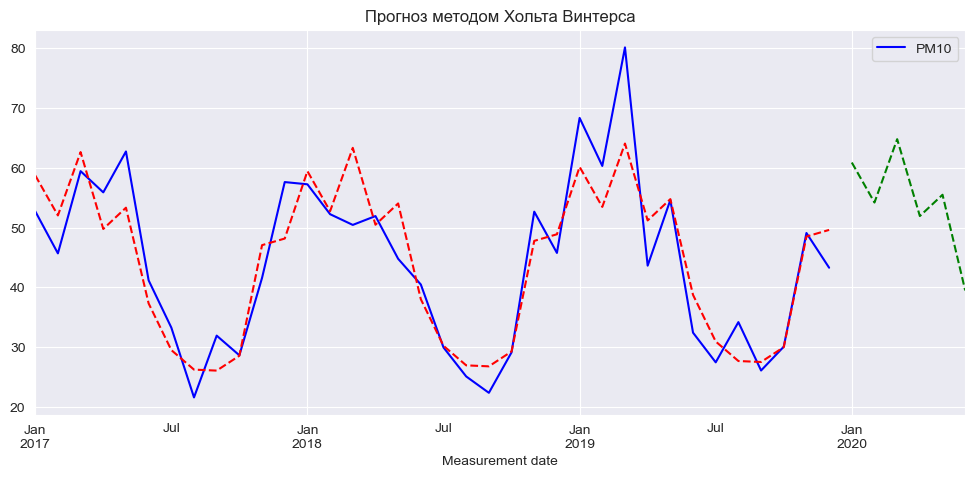

In [46]:
ax = df_PM10_sum.plot(figsize=(12,5), color='blue', title="Прогноз методом Хольта Винтерса" )
fit_PM10.fittedvalues.plot(ax=ax, style='--', color='red')
fit_PM10.forecast(6).plot(ax=ax, style='--', color='green')
plt.show()

•	Корреляционный анализ: есть ли связь между концентрацией SO2 и NO2

In [126]:
so2 = df_sum_ser['SO2']
no2 = df_sum_ser['NO2']

# Calculate the correlation coefficient
correlation = so2.corr(no2)

print(f"Correlation coefficient between SO2 and NO2: {correlation}")

Correlation coefficient between SO2 and NO2: 0.7438982061904988


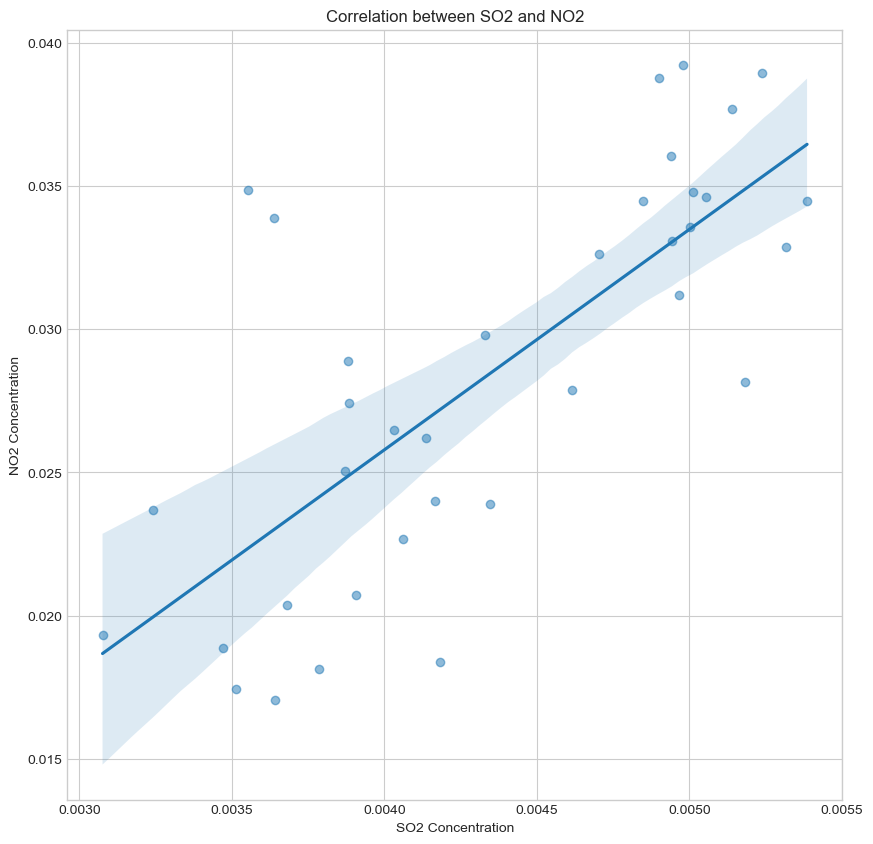

In [128]:
sns.regplot(x=so2, y=no2, scatter_kws={'alpha': 0.5})
plt.xlabel('SO2 Concentration')
plt.ylabel('NO2 Concentration')
plt.title('Correlation between SO2 and NO2')
plt.show()

•	Cвободный анализ на ваше усмотрение

In [47]:
df_summary = pd.read_csv('Measurement_summary.csv')

# Loop through columns and replace negative values with zero
for col in df_summary.columns[5:10]: 
    df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')  # Convert column to numeric type
    df_summary.loc[df_summary[col] < 0, col] = 0  # Replace negative values with zero

# Convert 'Measurement date' to datetime
df_summary['Measurement date'] = pd.to_datetime(df_summary['Measurement date'])

# Resample to monthly frequency and apply mean to pollutants
df_monthly_mean = df_summary.set_index('Measurement date').resample('M')[['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']].mean()

# Create a new DataFrame for resampled 'Station code' column
df_station_code = df_summary.set_index('Measurement date')['Station code'].resample('M').first()

# Merge the resampled dataframes
df_monthly_summary = pd.concat([df_station_code, df_monthly_mean], axis=1)

thresholds = {
    'SO2': [0.002, 0.005, 0.015, 0.1],
    'NO2': [0.03, 0.06, 0.2, 2.0],
    'CO': [2.0, 9.0, 15.0, 50.0],
    'O3': [0.03, 0.09, 0.15, 0.5],
    'PM10': [30.0, 80.0, 150.0, 600.0],
    'PM2.5': [15.0, 35.0, 75.0, 500.0]
}

# Function to assign colors based on thresholds
def assign_color(value, thresholds):
    if value >= 0 and value < thresholds[1]:
        return 'blue'
    elif value < thresholds[2] and value >= thresholds[1]:
        return 'green'
    elif value < thresholds[3] and value >= thresholds[2]:
        return 'yellow'
    elif value >= thresholds[3]:
        return 'red'

# Iterate over the pollutant columns and assign colors
for pollutant in thresholds.keys():
    threshold_values = thresholds[pollutant]
    color_column = f'{pollutant} Color'
    df_monthly_summary[color_column] = df_monthly_summary[pollutant].apply(lambda x: assign_color(x, threshold_values))


In [231]:
df_monthly_summary.head()

,Station code,SO2,NO2,O3,CO,PM10,PM2.5,SO2 Color,NO2 Color,CO Color,O3 Color,PM10 Color,PM2.5 Color
Measurement date,,,,,,,,,,,,,
2017-01-31,101,0.005012,0.034788,0.014110,0.702651,52.752366,32.525000,green,blue,blue,blue,blue,blue
2017-02-28,101,0.005055,0.034625,0.018249,0.634208,45.703214,28.545179,green,blue,blue,blue,blue,blue
2017-03-31,101,0.005140,0.037669,0.024718,0.591720,59.455914,39.610376,green,blue,blue,blue,blue,green
2017-04-30,101,0.004966,0.031194,0.034605,0.504556,55.906278,26.233000,blue,blue,blue,blue,blue,blue
2017-05-31,101,0.005183,0.028162,0.038675,0.431543,62.747097,24.309946,green,blue,blue,blue,blue,blue


In [51]:
pollutants = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

colors = ['blue', 'green', 'yellow', 'red']

for pollutant in pollutants:
    for color in colors:
        color_counts = df_monthly_summary[df_monthly_summary[f'{pollutant} Color'] == color]['Station code'].value_counts()
        if not color_counts.empty:
            station_with_most_color = color_counts.idxmax()
            print(f"Станция с самым большим количеством значений {color} для {pollutant}: {station_with_most_color}")
        else:
            print(f"Нет станций со значением {color} для {pollutant}.")

    print()

Станция с самым большим количеством значений blue для SO2: 101
Станция с самым большим количеством значений green для SO2: 101
Нет станций со значением yellow для SO2.
Нет станций со значением red для SO2.

Станция с самым большим количеством значений blue для NO2: 101
Нет станций со значением green для NO2.
Нет станций со значением yellow для NO2.
Нет станций со значением red для NO2.

Станция с самым большим количеством значений blue для O3: 101
Нет станций со значением green для O3.
Нет станций со значением yellow для O3.
Нет станций со значением red для O3.

Станция с самым большим количеством значений blue для CO: 101
Нет станций со значением green для CO.
Нет станций со значением yellow для CO.
Нет станций со значением red для CO.

Станция с самым большим количеством значений blue для PM10: 101
Станция с самым большим количеством значений green для PM10: 101
Нет станций со значением yellow для PM10.
Нет станций со значением red для PM10.

Станция с самым большим количеством значе

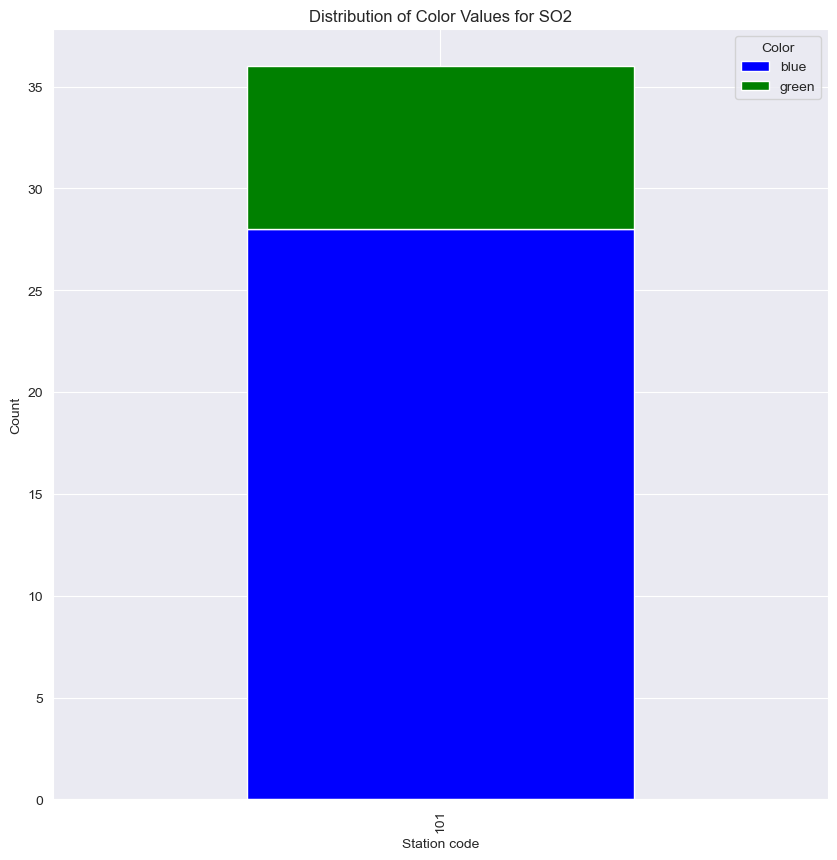

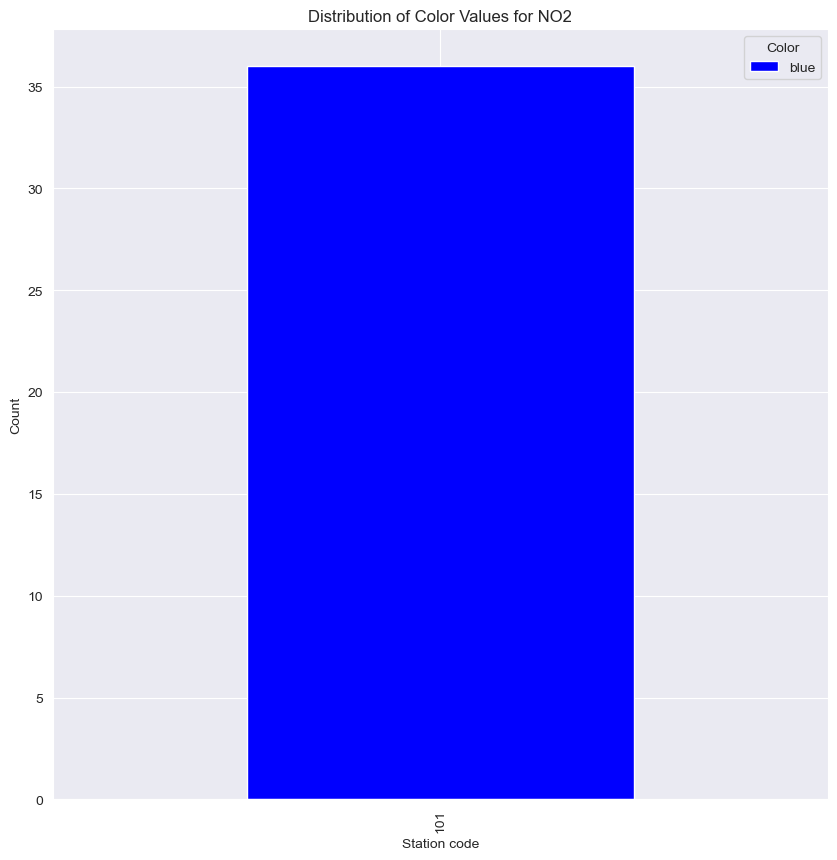

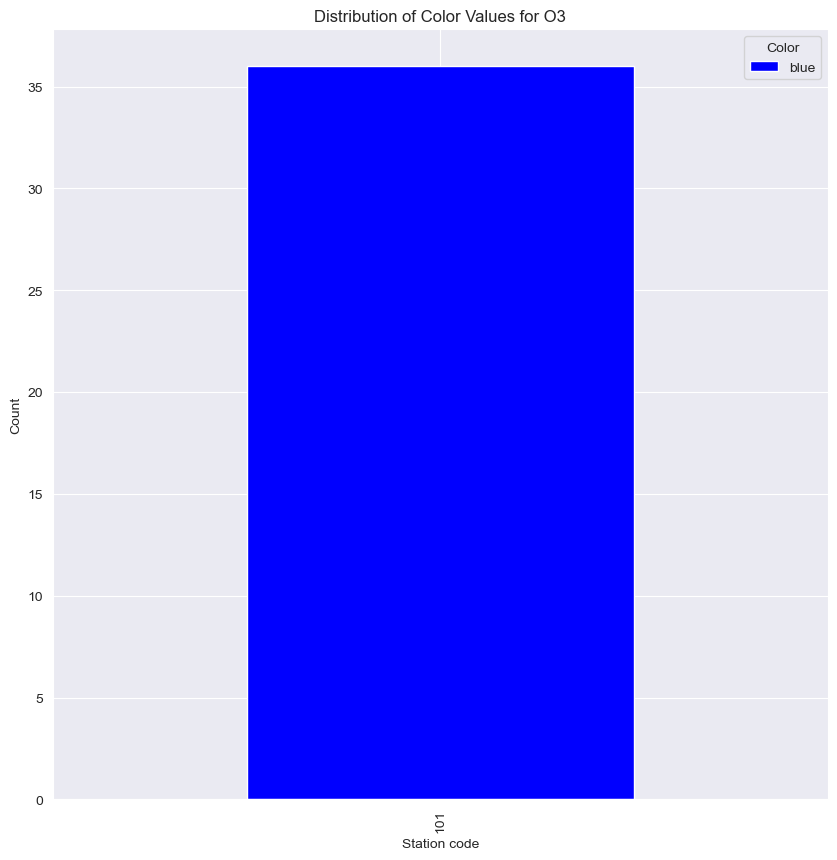

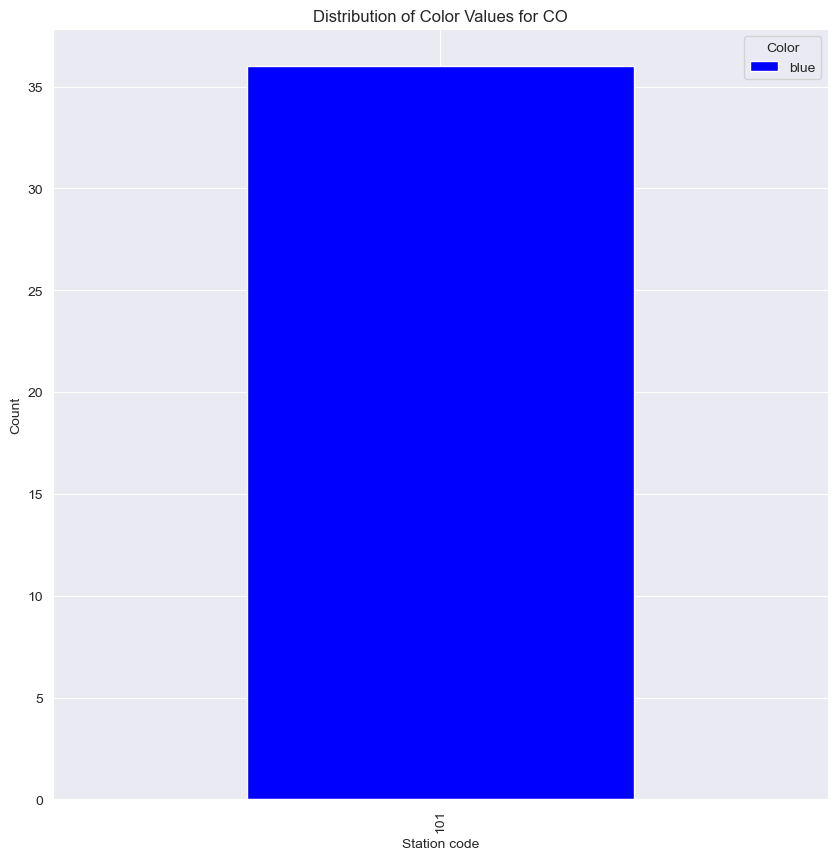

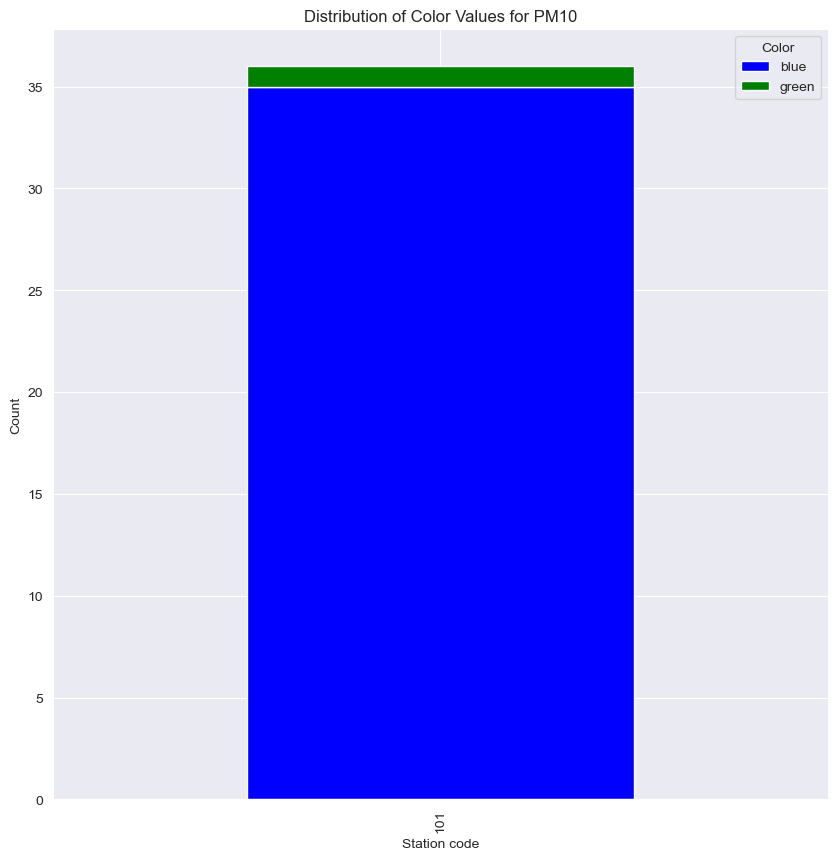

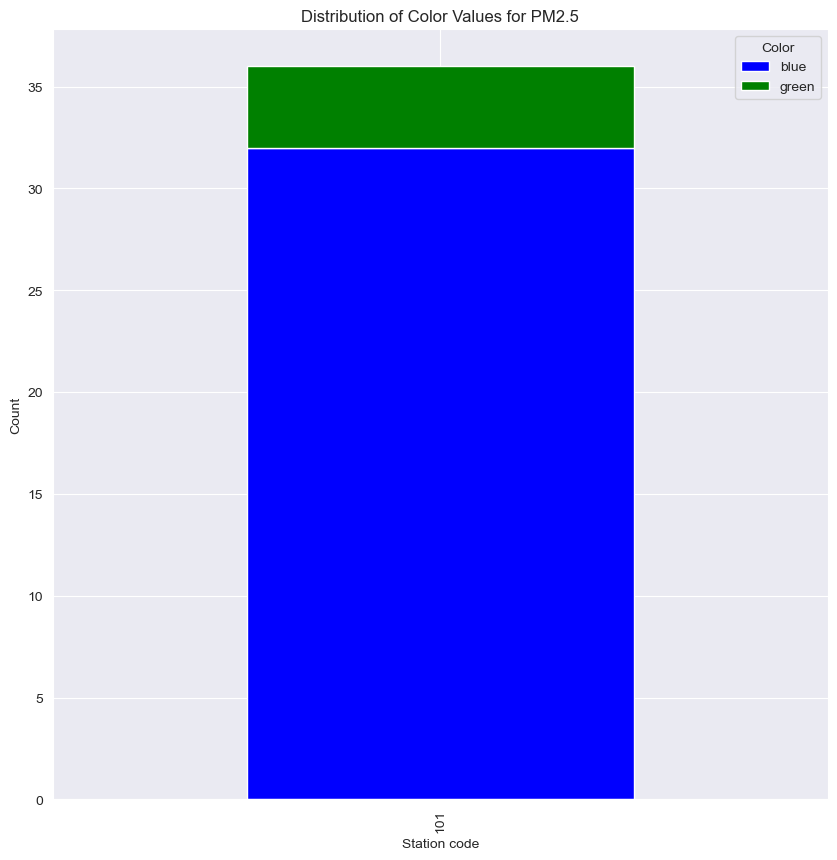

In [54]:
# Create a subset of the dataframe with relevant columns
df_color_counts = df_monthly_summary[['Station code', 'SO2 Color', 'NO2 Color', 'O3 Color', 'CO Color', 'PM10 Color', 'PM2.5 Color']]

# Set the order of color categories for the legend
color_order = ['blue', 'green', 'yellow', 'red']

# Iterate over each pollutant
for pollutant in pollutants:
    # Create a cross-tabulation of station codes and color values
    color_table = pd.crosstab(df_color_counts['Station code'], df_color_counts[f'{pollutant} Color'])

    # Plot the stacked bar chart
    color_table.plot(kind='bar', stacked=True, color=color_order)
    plt.xlabel('Station code')
    plt.ylabel('Count')
    plt.title(f'Distribution of Color Values for {pollutant}')
    plt.legend(title='Color', loc='upper right', labels=color_order)
    plt.show()
